## 패키지 설치 및 불러오기

In [ ]:

# 1. 라이브러리 임포트

%pip install yfinance  # (Colab 등에서 필요 시)
%pip install tensorflow
%pip install matplot
%pip install seaborn
%pip install ta
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import random



## 모델 구축

1. 단순 분할(80/20) | Sentiment값 0으로 고정


In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# RMSE 계산 함수 정의
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

# MAE 계산 함수 정의 (sklearn 사용)
def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

# MAPE 계산 함수 정의
def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    # 실제값이 0이면 작은 값으로 대체하여 계산
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# 결과 저장을 위한 빈 딕셔너리 초기화
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'RMSE (with sentiment)': [],
}

# 기존 결과 파일이 있는지 확인하고, 있다면 불러오기
results_file_path = "/content/drive/MyDrive/LSTM_results.csv"
if os.path.isfile(results_file_path):
    existing_results = pd.read_csv(results_file_path)
else:
    existing_results = None

# (예시) 여러 종목에 대한 Ticker를 담은 딕셔너리
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}

# 예시: 2020-01-01 ~ 2023-01-01 구간
start_date = "2024-01-01"
end_date   = "2025-01-01"

#----------------------------------------------
# LSTM 윈도우 구성 함수
#----------------------------------------------
def create_dataset(dataset, seq_size):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size])
    return np.array(X), np.array(Y)

#----------------------------------------------
# 각 종목별로 학습/예측 수행
#----------------------------------------------
for company_name, company_code in stock_dict.items():
    #==============================================
    # 1) "No Sentiment": 야후 파이낸스 데이터만
    #==============================================
    df_no_sentiment = yf.download(company_code, start=start_date, end=end_date, progress=False)
    df_no_sentiment.reset_index(inplace=True)
    df_no_sentiment = df_no_sentiment[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df_no_sentiment.fillna(method='ffill', inplace=True)

    #==============================================
    # 2) "With Sentiment": 0으로 고정된 컬럼 추가
    #==============================================
    df_with_sentiment = df_no_sentiment.copy()
    df_with_sentiment["Sentiment"] = 0.0

    # 결과를 저장할 리스트
    rmse_results_no_sentiment = []
    rmse_results_with_sentiment = []

    seq_size = 10  # 시퀀스 길이

    #----------------------------------------------------------------
    # (A) No Sentiment 케이스
    #----------------------------------------------------------------
    # date 제외 -> ['Open','High','Low','Close','Volume']
    columns_no_sentiment = df_no_sentiment.columns[1:]
    data_no_sentiment = df_no_sentiment.iloc[:, 1:].values.astype(float)
    scaler_no_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_no_sentiment = scaler_no_sentiment.fit_transform(data_no_sentiment)
    X, Y_data = create_dataset(scaled_data_no_sentiment, seq_size)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y_data[:train_size], Y_data[train_size:]

    model = Sequential()
    model.add(LSTM(50, return_sequences=True,
                   input_shape=(seq_size, len(columns_no_sentiment)),
                   kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(len(columns_no_sentiment)))
    model.compile(optimizer='adam', loss='mean_squared_error')

    def scheduler(epoch, lr):
        return lr * 0.99
    callback = LearningRateScheduler(scheduler)

    model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
              epochs=50, batch_size=32, callbacks=[callback], verbose=1)

    predictions = model.predict(X_test)
    rmse_no_sent = calculate_rmse(Y_test, predictions)
    mae_no_sent = calculate_mae(Y_test, predictions)
    mape_no_sent = calculate_mape(Y_test, predictions)
    rmse_results_no_sentiment.append(rmse_no_sent)

    print(f"\n{company_name} (No Sentiment) Metrics:")
    print("  RMSE: {:.4f}".format(rmse_no_sent))
    print("  MAE: {:.4f}".format(mae_no_sent))
    print("  MAPE: {:.2f}%".format(mape_no_sent))
    # 개별 샘플 오차 확인 (첫 5개 샘플)
    for i in range(5):
        error = Y_test[i] - predictions[i]
        print(f"  Sample {i+1} - Actual: {Y_test[i]}, Predicted: {predictions[i]}, Error: {error}")
    # ±5% 오차 내 정확도 계산
    threshold = 0.05
    relative_errors = np.abs((Y_test - predictions) / np.where(Y_test==0, 0.001, Y_test))
    accurate_ratio = np.mean(relative_errors < threshold)
    print("  Accuracy (within ±5% error): {:.2f}%".format(accurate_ratio * 100))

    #----------------------------------------------------------------
    # (B) With Sentiment 케이스 (Sentiment=0)
    #----------------------------------------------------------------
    # date 제외 -> ['Open','High','Low','Close','Volume','Sentiment']
    columns_with_sentiment = df_with_sentiment.columns[1:]
    data_with_sentiment = df_with_sentiment.iloc[:, 1:].values.astype(float)
    scaler_with_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_with_sentiment = scaler_with_sentiment.fit_transform(data_with_sentiment)
    X_s, Y_data_s = create_dataset(scaled_data_with_sentiment, seq_size)

    train_size_s = int(len(X_s) * 0.8)
    X_train_s, X_test_s = X_s[:train_size_s], X_s[train_size_s:]
    Y_train_s, Y_test_s = Y_data_s[:train_size_s], Y_data_s[train_size_s:]

    model_s = Sequential()
    model_s.add(LSTM(50, return_sequences=True,
                     input_shape=(seq_size, len(columns_with_sentiment)),
                     kernel_regularizer=l2(1e-5)))
    model_s.add(Dropout(0.2))
    model_s.add(LSTM(50, kernel_regularizer=l2(1e-5)))
    model_s.add(Dropout(0.2))
    model_s.add(Dense(len(columns_with_sentiment)))
    model_s.compile(optimizer='adam', loss='mean_squared_error')

    model_s.fit(X_train_s, Y_train_s, validation_data=(X_test_s, Y_test_s),
                epochs=50, batch_size=32, callbacks=[callback], verbose=1)

    predictions_s = model_s.predict(X_test_s)
    rmse_with_sent = calculate_rmse(Y_test_s, predictions_s)
    mae_with_sent = calculate_mae(Y_test_s, predictions_s)
    mape_with_sent = calculate_mape(Y_test_s, predictions_s)
    rmse_results_with_sentiment.append(rmse_with_sent)

    print(f"\n{company_name} (With Sentiment=0) Metrics:")
    print("  RMSE: {:.4f}".format(rmse_with_sent))
    print("  MAE: {:.4f}".format(mae_with_sent))
    print("  MAPE: {:.2f}%".format(mape_with_sent))
    # 개별 샘플 오차 확인 (첫 5개 샘플)
    for i in range(5):
        error = Y_test_s[i] - predictions_s[i]
        print(f"  Sample {i+1} - Actual: {Y_test_s[i]}, Predicted: {predictions_s[i]}, Error: {error}")
    # ±5% 오차 내 정확도 계산
    relative_errors_s = np.abs((Y_test_s - predictions_s) / np.where(Y_test_s==0, 0.001, Y_test_s))
    accurate_ratio_s = np.mean(relative_errors_s < threshold)
    print("  Accuracy (within ±5% error): {:.2f}%".format(accurate_ratio_s * 100))

    #----------------------------------------------------------------
    # 결과 출력 및 저장
    #----------------------------------------------------------------
    print(f"\n{company_name} (No Sentiment) RMSE: {rmse_results_no_sentiment}")
    print(f"{company_name} (With Sentiment=0) RMSE: {rmse_results_with_sentiment}")

    results['Company'].append(company_code)
    results['RMSE (no sentiment)'].append(rmse_results_no_sentiment)
    results['RMSE (with sentiment)'].append(rmse_results_with_sentiment)

df_results = pd.DataFrame(results)
print("\nFinal Results:")
print(df_results)

Epoch 1/50


/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/544065624.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_no_sentiment.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1501 - val_loss: 0.2399 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0731 - val_loss: 0.0532 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0252 - val_loss: 0.0096 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189 - val_loss: 0.0223 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0161 - val_loss: 0.0165 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142 - val_loss: 0.0128 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0129 - learning_rate: 9.3207e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0126 - val_loss: 0.0088 - learning_rate: 9.2274e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - val_loss: 0.0068 - learning_rate: 9.1352e-04
Epoch 10/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1091 - val_loss: 0.1232 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0316 - val_loss: 0.0085 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0226 - val_loss: 0.0096 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - val_loss: 0.0330 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0179 - val_loss: 0.0242 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - val_loss: 0.0081 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107 - val_loss: 0.0068 - learning_rate: 9.3207e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0106 - val_loss: 0.0104 - learning_rate: 9.2274e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - val_loss: 0.0087 - learning_rate: 9.1352e-04
Epoch 10/50


/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/544065624.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_no_sentiment.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1990 - val_loss: 0.1086 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0603 - val_loss: 0.0230 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0326 - val_loss: 0.0173 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0275 - val_loss: 0.0257 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0242 - val_loss: 0.0211 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0225 - val_loss: 0.0163 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212 - val_loss: 0.0160 - learning_rate: 9.3207e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0204 - val_loss: 0.0153 - learning_rate: 9.2274e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0197 - val_loss: 0.0156 - learning_rate: 9.1352e-04
Epoch 10/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1806 - val_loss: 0.1116 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0625 - val_loss: 0.0178 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0308 - val_loss: 0.0168 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269 - val_loss: 0.0214 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0231 - val_loss: 0.0189 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 - val_loss: 0.0146 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0196 - val_loss: 0.0123 - learning_rate: 9.3207e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - val_loss: 0.0153 - learning_rate: 9.2274e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - val_loss: 0.0144 - learning_rate: 9.1352e-04
Epoch 10/50
6/6 ━━

## Rolling Window | LSTM(50) → Dropout → LSTM(50) → Dropout → Dense(len(columns))

In [ ]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------------------------------
# 지표 계산 함수
# --------------------------------------------
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)  # 0으로 나누는 것 방지
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# --------------------------------------------
# 시계열 데이터 구성 (종가만 예측)
# --------------------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])  # 종가만 예측
    return np.array(X), np.array(Y)

# --------------------------------------------
# 롤링 윈도우 LSTM 학습/예측
# --------------------------------------------
def rolling_window_evaluation(X, Y, seq_size, input_dim,
                              epochs=50, batch_size=32,
                              train_window=500, test_window=100):
    total_samples = len(X)
    metrics_list = []

    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test = X[start + train_window: start + train_window + test_window]
        Y_test = Y[start + train_window: start + train_window + test_window]

        model = Sequential()
        model.add(LSTM(50, return_sequences=True,
                       input_shape=(seq_size, input_dim),
                       kernel_regularizer=l2(1e-5)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, kernel_regularizer=l2(1e-5)))
        model.add(Dropout(0.2))
        model.add(Dense(1))  # 종가 하나만 예측
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr):
            return lr * 0.99
        callback = LearningRateScheduler(scheduler)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)

        predictions = model.predict(X_test)
        rmse = calculate_rmse(Y_test, predictions)
        mae = calculate_mae(Y_test, predictions)
        mape = calculate_mape(Y_test, predictions)

        metrics_list.append((rmse, mae, mape))

    return metrics_list

# --------------------------------------------
# 설정
# --------------------------------------------
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'RMSE (with sentiment)': [],
}

results_file_path = "LSTM_results.csv"
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}
start_date = "2020-01-01"
end_date   = "2025-01-01"
seq_size = 10
target_index = 3  # 'Close' 컬럼 위치

# --------------------------------------------
# 종목별 학습 루프
# --------------------------------------------
for company_name, company_code in stock_dict.items():
    print(f"\n📈 Processing {company_name} ({company_code})...")

    # 1) 야후 파이낸스 데이터 수집
    df = yf.download(company_code, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.ffill(inplace=True)

    # 2) 감성 분석 없는 케이스
    df_no_sentiment = df.copy()
    cols_no = df_no_sentiment.columns[1:]
    data_no = df_no_sentiment[cols_no].values.astype(float)
    scaler_no = MinMaxScaler()
    scaled_no = scaler_no.fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size, target_index)

    metrics_no = rolling_window_evaluation(X_no, Y_no, seq_size, len(cols_no),
                                           epochs=50, batch_size=32,
                                           train_window=500, test_window=100)

    avg_rmse_no = np.mean([m[0] for m in metrics_no])
    avg_mae_no  = np.mean([m[1] for m in metrics_no])
    avg_mape_no = np.mean([m[2] for m in metrics_no])

    print(f"{company_name} (No Sentiment) Metrics:")
    print(f"  ✅ RMSE:  {avg_rmse_no:.4f}")
    print(f"  ✅ MAE:   {avg_mae_no:.4f}")
    print(f"  ✅ MAPE:  {avg_mape_no:.2f}%")

    # 3) 감성 점수 포함 (0으로 초기화)
    df_with_sentiment = df.copy()
    df_with_sentiment["Sentiment"] = 0.0
    cols_with = df_with_sentiment.columns[1:]
    data_with = df_with_sentiment[cols_with].values.astype(float)
    scaler_with = MinMaxScaler()
    scaled_with = scaler_with.fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size, target_index)

    metrics_with = rolling_window_evaluation(X_with, Y_with, seq_size, len(cols_with),
                                             epochs=50, batch_size=32,
                                             train_window=500, test_window=100)

    avg_rmse_with = np.mean([m[0] for m in metrics_with])
    avg_mae_with  = np.mean([m[1] for m in metrics_with])
    avg_mape_with = np.mean([m[2] for m in metrics_with])

    print(f"{company_name} (With Sentiment = 0) Metrics:")
    print(f"  ✅ RMSE:  {avg_rmse_with:.4f}")
    print(f"  ✅ MAE:   {avg_mae_with:.4f}")
    print(f"  ✅ MAPE:  {avg_mape_with:.2f}%")

    # 결과 저장
    results['Company'].append(company_code)
    results['RMSE (no sentiment)'].append(avg_rmse_no)
    results['RMSE (with sentiment)'].append(avg_rmse_with)

# --------------------------------------------
# 최종 결과 저장
# --------------------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)
print("\n📊 Final Results:")
print(df_results)

## 기본 LSTM + Rolling Window (저장부분, 평가지표 추가) 코드 수정

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

📈 Apple (AAPL)
[No Sentiment]  RMSE: 0.0472, MAE: 0.0397, MAPE: 14.62%, Accuracy: 23.95%
[With Sentiment] RMSE: 0.0531, MAE: 0.0435, MAPE: 14.51%, Accuracy: 23.46%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

📈 Microsoft (MSFT)
[No Sentiment]  RMSE: 0.0409, MAE: 0.0324, MAPE: 7.43%, Accuracy: 41.33%
[With Sentiment] RMSE: 0.0374, MAE: 0.0300, MAPE: 7.27%, Accuracy: 42.75%


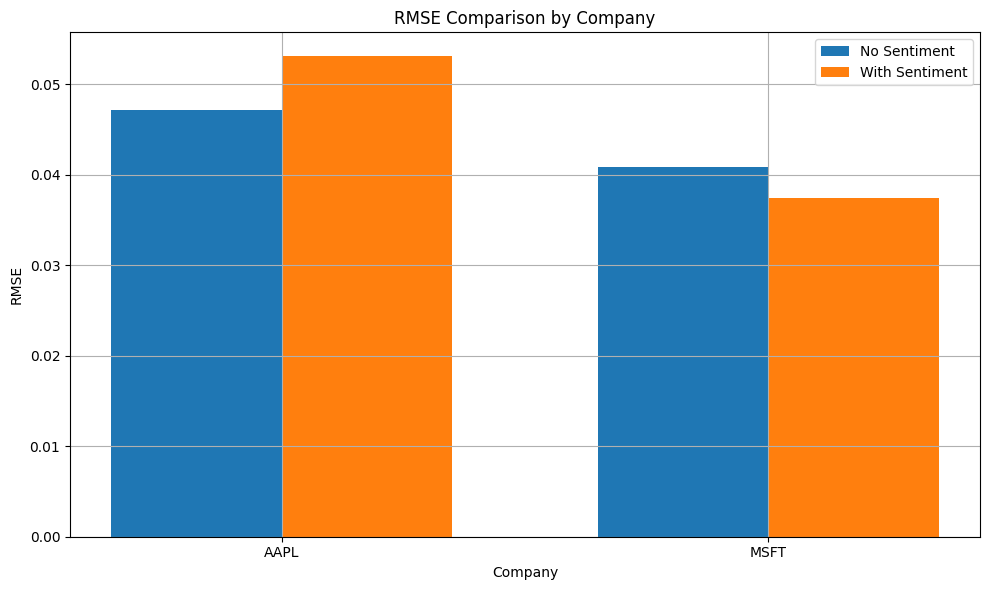

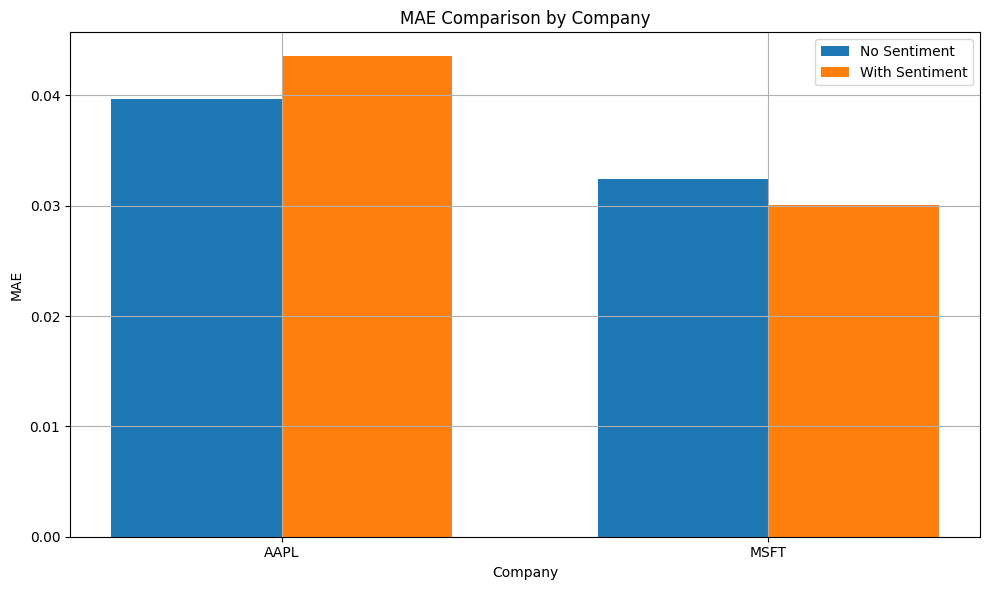

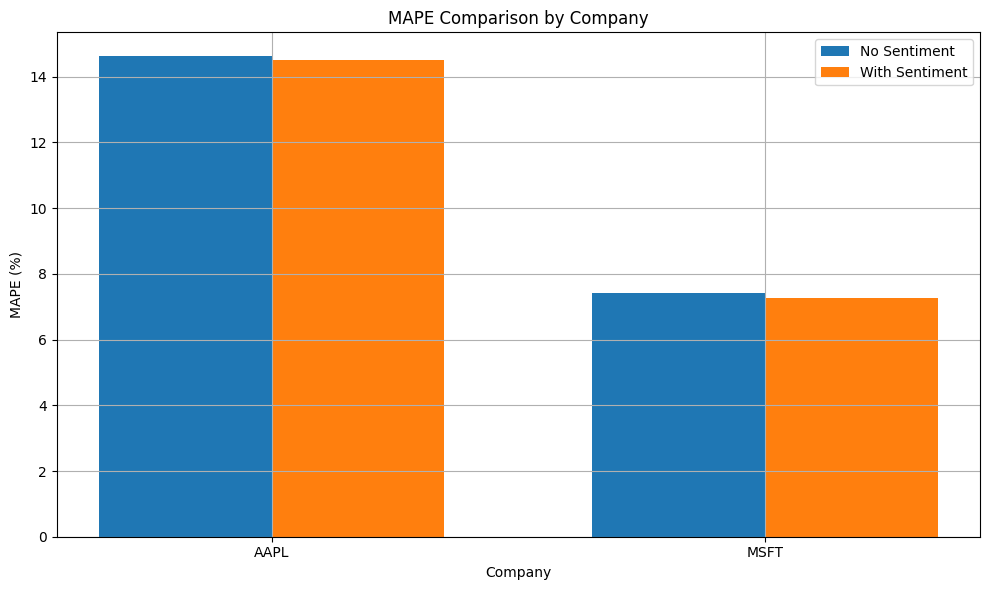

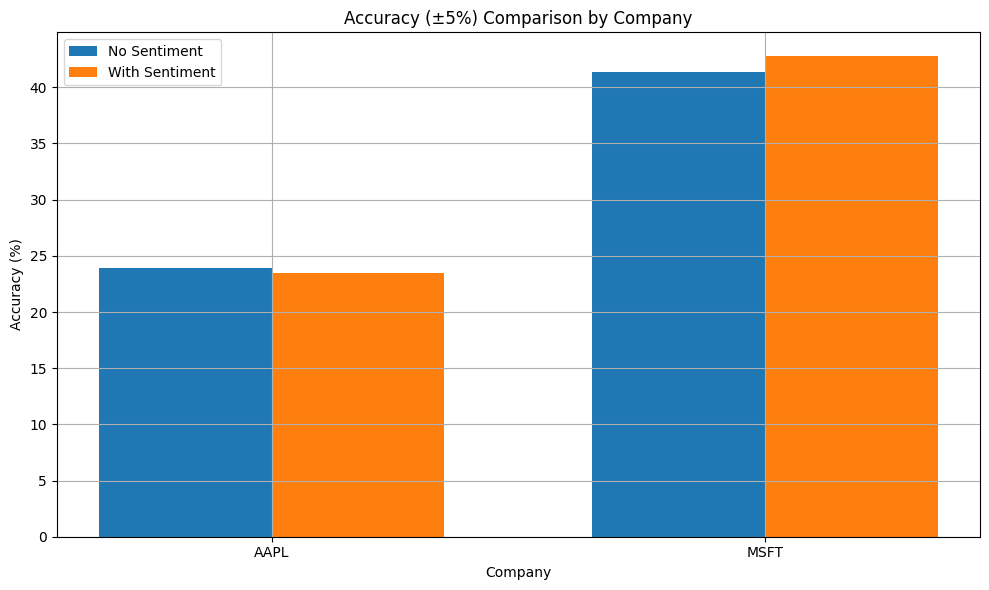

In [8]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
# 폴더 생성 및 설정
# ------------------------------
os.makedirs("results", exist_ok=True)
results_file_path = "./results/LSTM_results.csv"

# ------------------------------
# 지표 계산 함수
# ------------------------------
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# ------------------------------
# 데이터셋 구성 함수
# ------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])
    return np.array(X), np.array(Y)

# ------------------------------
# 롤링 윈도우 평가 함수
# ------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    total_samples = len(X)
    metrics_list = []

    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test  = X[start + train_window: start + train_window + test_window]
        Y_test  = Y[start + train_window: start + train_window + test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr):
            return lr * 0.99
        callback = LearningRateScheduler(scheduler)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)

        predictions = model.predict(X_test)
        rmse = calculate_rmse(Y_test, predictions)
        mae = calculate_mae(Y_test, predictions)
        mape = calculate_mape(Y_test, predictions)
        relative_errors = np.abs((Y_test - predictions) / np.where(Y_test == 0, 0.001, Y_test))
        accuracy = np.mean(relative_errors < threshold) * 100

        metrics_list.append((rmse, mae, mape, accuracy))

    return metrics_list

# ------------------------------
# 학습 및 평가 실행
# ------------------------------
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'MAE (no sentiment)': [],
    'MAPE (no sentiment)': [],
    'Accuracy (no sentiment)': [],
    'RMSE (with sentiment)': [],
    'MAE (with sentiment)': [],
    'MAPE (with sentiment)': [],
    'Accuracy (with sentiment)': [],
}

stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}
start_date = "2022-01-01"
end_date = "2025-01-01"
seq_size = 10
target_index = 3

for company_name, ticker in stock_dict.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.ffill(inplace=True)

    df_with_sentiment = df.copy()
    df_with_sentiment['Sentiment'] = 0.0

    # No Sentiment
    cols_no = df.columns[1:]
    data_no = df[cols_no].values.astype(float)
    scaler_no = MinMaxScaler()
    scaled_no = scaler_no.fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size, target_index)

    metrics_no = rolling_window_evaluation(X_no, Y_no, seq_size, cols_no)
    if not metrics_no:
        continue

    avg_rmse_no = np.mean([m[0] for m in metrics_no])
    avg_mae_no = np.mean([m[1] for m in metrics_no])
    avg_mape_no = np.mean([m[2] for m in metrics_no])
    avg_acc_no = np.mean([m[3] for m in metrics_no])

    # With Sentiment
    cols_with = df_with_sentiment.columns[1:]
    data_with = df_with_sentiment[cols_with].values.astype(float)
    scaler_with = MinMaxScaler()
    scaled_with = scaler_with.fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size, target_index)

    metrics_with = rolling_window_evaluation(X_with, Y_with, seq_size, cols_with)
    if not metrics_with:
        continue

    avg_rmse_with = np.mean([m[0] for m in metrics_with])
    avg_mae_with = np.mean([m[1] for m in metrics_with])
    avg_mape_with = np.mean([m[2] for m in metrics_with])
    avg_acc_with = np.mean([m[3] for m in metrics_with])

    print(f"\n📈 {company_name} ({ticker})")
    print(f"[No Sentiment]  RMSE: {avg_rmse_no:.4f}, MAE: {avg_mae_no:.4f}, MAPE: {avg_mape_no:.2f}%, Accuracy: {avg_acc_no:.2f}%")
    print(f"[With Sentiment] RMSE: {avg_rmse_with:.4f}, MAE: {avg_mae_with:.4f}, MAPE: {avg_mape_with:.2f}%, Accuracy: {avg_acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(avg_rmse_no)
    results['MAE (no sentiment)'].append(avg_mae_no)
    results['MAPE (no sentiment)'].append(avg_mape_no)
    results['Accuracy (no sentiment)'].append(avg_acc_no)
    results['RMSE (with sentiment)'].append(avg_rmse_with)
    results['MAE (with sentiment)'].append(avg_mae_with)
    results['MAPE (with sentiment)'].append(avg_mape_with)
    results['Accuracy (with sentiment)'].append(avg_acc_with)

# 결과 저장
df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)

# ------------------------------
# 시각화 함수
# ------------------------------
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    x = df_results['Company']
    no_sentiment = df_results[f'{metric_name} (no sentiment)']
    with_sentiment = df_results[f'{metric_name} (with sentiment)']

    bar_width = 0.35
    index = range(len(x))

    plt.bar(index, no_sentiment, bar_width, label='No Sentiment')
    plt.bar([i + bar_width for i in index], with_sentiment, bar_width, label='With Sentiment')

    plt.xlabel('Company')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([i + bar_width / 2 for i in index], x)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 시각화 실행
# ------------------------------
plot_metric("RMSE", "RMSE Comparison by Company", "RMSE")
plot_metric("MAE", "MAE Comparison by Company", "MAE")
plot_metric("MAPE", "MAPE Comparison by Company", "MAPE (%)")
plot_metric("Accuracy", "Accuracy (±5%) Comparison by Company", "Accuracy (%)")


## 코드 2 : 기본 LSTM + 시각화

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━

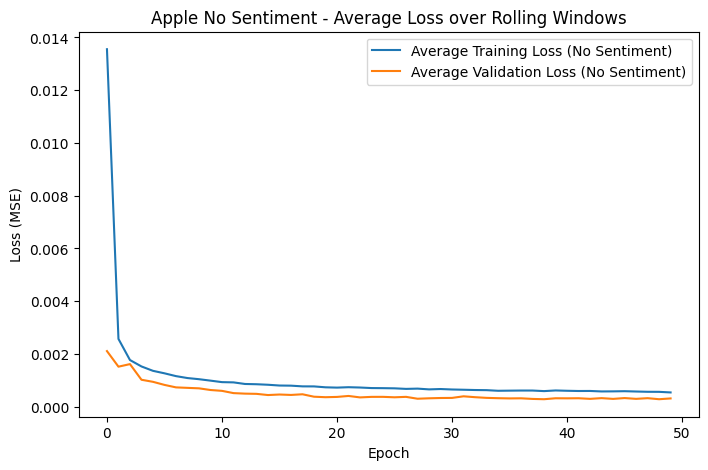

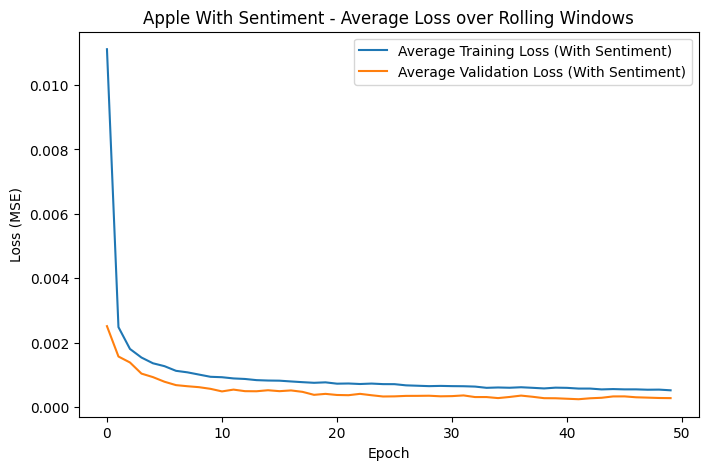

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━

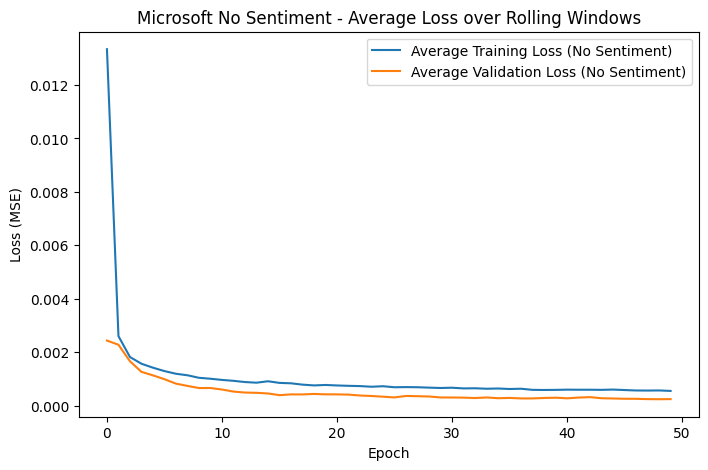

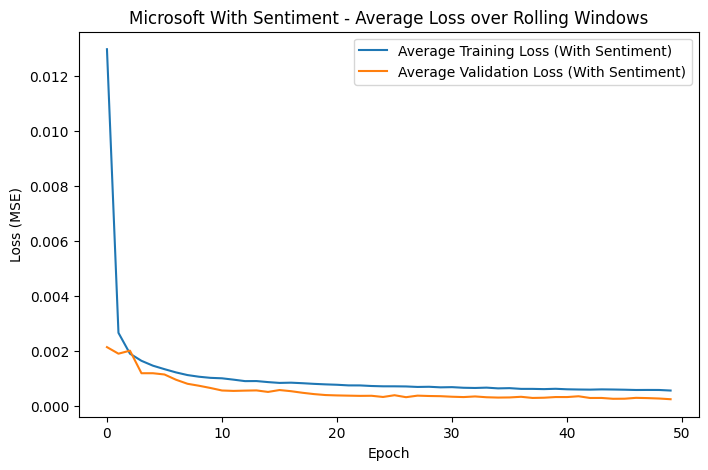


Final Results:
  Company  RMSE (no sentiment)  Accuracy (no sentiment)  \
0    AAPL             0.007627                35.660877   
1    MSFT             0.006841                33.923158   

   RMSE (with sentiment)  Accuracy (with sentiment)  
0               0.007263                  33.922281  
1               0.006642                  33.432807  


In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# 결과 저장할 디렉토리 생성 (없으면 생성)
os.makedirs("results", exist_ok=True)

# RMSE, MAE, MAPE 계산 함수 정의
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# 결과 저장을 위한 빈 딕셔너리 초기화
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'Accuracy (no sentiment)': [],
    'RMSE (with sentiment)': [],
    'Accuracy (with sentiment)': [],
}

results_file_path = "./results/LSTM_results.csv"
if os.path.isfile(results_file_path):
    existing_results = pd.read_csv(results_file_path)
else:
    existing_results = None

# 여러 종목에 대한 Ticker
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}

# 데이터 기간 설정
start_date = "2000-01-01"
end_date   = "2025-01-01"

#----------------------------------------------
# LSTM 윈도우 구성 함수 (target_index를 이용하여 종가만 예측)
#----------------------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])
    return np.array(X), np.array(Y)

#----------------------------------------------
# 롤링 윈도우 학습/검증 함수 (제안된 모델 적용)
#----------------------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    total_samples = len(X)
    metrics_list = []  # 각 윈도우의 (rmse, mae, mape, accuracy)
    history_list = []  # 각 윈도우의 history.history (loss, val_loss)
    
    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test  = X[start + train_window: start + train_window + test_window]
        Y_test  = Y[start + train_window: start + train_window + test_window]
        
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        def scheduler(epoch, lr):
            return lr * 0.99
        callback = LearningRateScheduler(scheduler)
        
        history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)
        
        history_list.append(history.history)
        
        predictions = model.predict(X_test)
        rmse_val = calculate_rmse(Y_test, predictions)
        mae_val  = calculate_mae(Y_test, predictions)
        mape_val = calculate_mape(Y_test, predictions)
        relative_errors = np.abs((Y_test - predictions) / np.where(Y_test==0, 0.001, Y_test))
        accuracy = np.mean(relative_errors < threshold) * 100
        metrics_list.append((rmse_val, mae_val, mape_val, accuracy))
    return metrics_list, history_list

#----------------------------------------------
# 각 종목별로 Rolling Window 방식으로 학습/예측 수행 (종가 예측용)
#----------------------------------------------
# 예측 대상: 종가 ("Close") → No Sentiment에서는 ['Open','High','Low','Close','Volume']에서 Close는 인덱스 3  
# With Sentiment의 경우에도 동일하게, ['Open','High','Low','Close','Volume','Sentiment']에서 Close는 인덱스 3
target_index = 3

for company_name, company_code in stock_dict.items():
    # 1) "No Sentiment": 야후 파이낸스 데이터만
    df_no_sentiment = yf.download(company_code, start=start_date, end=end_date, progress=False)
    df_no_sentiment.reset_index(inplace=True)
    df_no_sentiment = df_no_sentiment[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df_no_sentiment.ffill(inplace=True)
    
    # 2) "With Sentiment": 0으로 고정된 컬럼 추가
    df_with_sentiment = df_no_sentiment.copy()
    df_with_sentiment["Sentiment"] = 0.0

    seq_size = 10

    # --- No Sentiment 케이스 ---
    columns_no_sentiment = df_no_sentiment.columns[1:]  # ['Open','High','Low','Close','Volume']
    data_no_sentiment = df_no_sentiment.iloc[:, 1:].values.astype(float)
    scaler_no_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_no_sentiment = scaler_no_sentiment.fit_transform(data_no_sentiment)
    X_no, Y_no = create_dataset(scaled_data_no_sentiment, seq_size, target_index)
    
    metrics_no, history_no = rolling_window_evaluation(X_no, Y_no, seq_size, columns_no_sentiment,
                                           epochs=50, batch_size=32,
                                           train_window=500, test_window=100, threshold=0.05)
    avg_rmse_no = np.mean([m[0] for m in metrics_no])
    avg_accuracy_no = np.mean([m[3] for m in metrics_no])
    
    print(f"\n{company_name} (No Sentiment) Rolling Window Metrics (종가 예측):")
    print("  Average RMSE: {:.4f}".format(avg_rmse_no))
    print("  Average Accuracy (±5% error): {:.2f}%".format(avg_accuracy_no))
    
    # --- With Sentiment 케이스 ---
    columns_with_sentiment = df_with_sentiment.columns[1:]  # ['Open','High','Low','Close','Volume','Sentiment']
    data_with_sentiment = df_with_sentiment.iloc[:, 1:].values.astype(float)
    scaler_with_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_with_sentiment = scaler_with_sentiment.fit_transform(data_with_sentiment)
    X_with, Y_with = create_dataset(scaled_data_with_sentiment, seq_size, target_index)
    
    metrics_with, history_with = rolling_window_evaluation(X_with, Y_with, seq_size, columns_with_sentiment,
                                             epochs=50, batch_size=32,
                                             train_window=500, test_window=100, threshold=0.05)
    avg_rmse_with = np.mean([m[0] for m in metrics_with])
    avg_accuracy_with = np.mean([m[3] for m in metrics_with])
    
    print(f"\n{company_name} (With Sentiment=0) Rolling Window Metrics (종가 예측):")
    print("  Average RMSE: {:.4f}".format(avg_rmse_with))
    print("  Average Accuracy (±5% error): {:.2f}%".format(avg_accuracy_with))
    
    results['Company'].append(company_code)
    results['RMSE (no sentiment)'].append(avg_rmse_no)
    results['Accuracy (no sentiment)'].append(avg_accuracy_no)
    results['RMSE (with sentiment)'].append(avg_rmse_with)
    results['Accuracy (with sentiment)'].append(avg_accuracy_with)

    # ----- 추가: 각 케이스의 모든 윈도우에서의 Loss 곡선 평균 시각화 -----
    # 예를 들어, No Sentiment 케이스의 경우:
    # history_no는 각 윈도우의 history dict 리스트이며, 각 dict에 'loss'와 'val_loss'가 있음.
    # 동일한 epoch 수(50)를 사용하므로, 각 epoch별 평균 loss를 계산할 수 있음.
    
    # No Sentiment loss 평균 계산
    train_losses_no = np.array([h['loss'] for h in history_no])
    val_losses_no = np.array([h['val_loss'] for h in history_no])
    avg_train_loss_no = np.mean(train_losses_no, axis=0)
    avg_val_loss_no = np.mean(val_losses_no, axis=0)
    
    plt.figure(figsize=(8, 5))
    plt.plot(avg_train_loss_no, label='Average Training Loss (No Sentiment)')
    plt.plot(avg_val_loss_no, label='Average Validation Loss (No Sentiment)')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title(f"{company_name} No Sentiment - Average Loss over Rolling Windows")
    plt.legend()
    plt.show()
    
    # With Sentiment loss 평균 계산
    train_losses_with = np.array([h['loss'] for h in history_with])
    val_losses_with = np.array([h['val_loss'] for h in history_with])
    avg_train_loss_with = np.mean(train_losses_with, axis=0)
    avg_val_loss_with = np.mean(val_losses_with, axis=0)
    
    plt.figure(figsize=(8, 5))
    plt.plot(avg_train_loss_with, label='Average Training Loss (With Sentiment)')
    plt.plot(avg_val_loss_with, label='Average Validation Loss (With Sentiment)')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title(f"{company_name} With Sentiment - Average Loss over Rolling Windows")
    plt.legend()
    plt.show()

df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)
print("\nFinal Results:")
print(df_results)

## 코드3 : 양방향 LSTM(Bidirectional LSTM)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

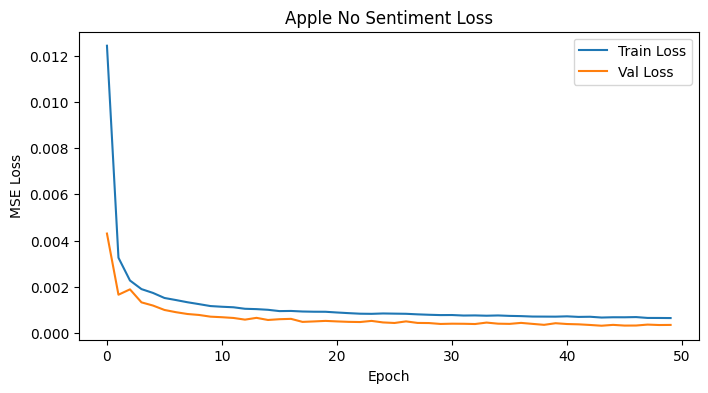

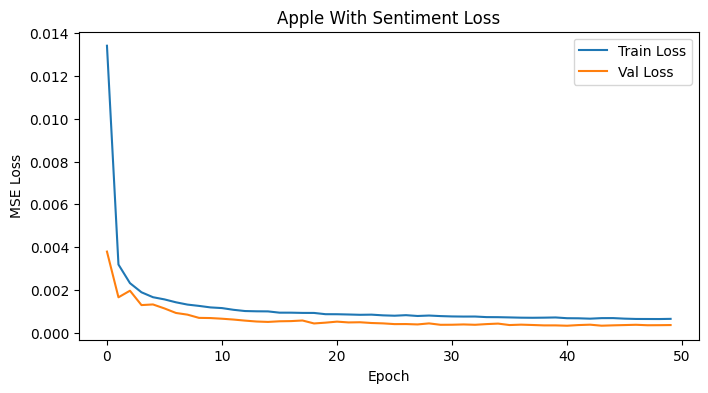

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9

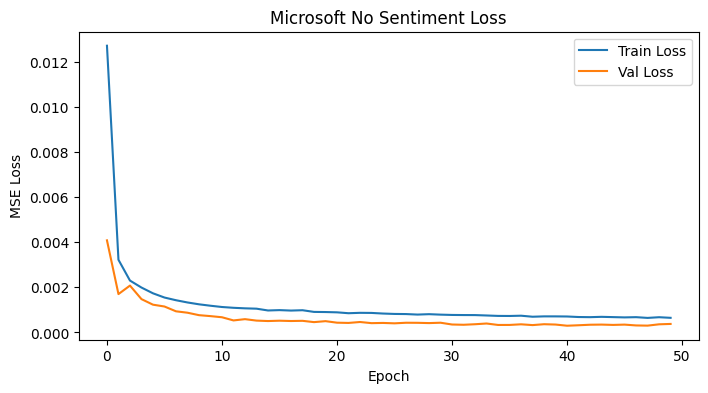

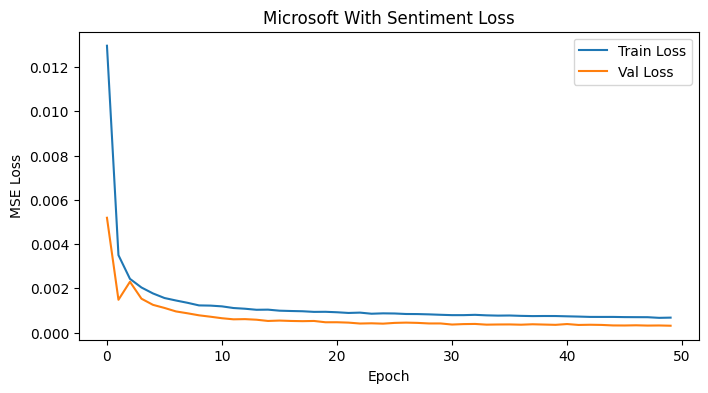


Final Results:
  Company  RMSE (no sentiment)  Accuracy (no sentiment)  \
0    AAPL             0.006889                35.355000   
1    MSFT             0.007408                33.637759   

   RMSE (with sentiment)  Accuracy (with sentiment)  
0               0.007310                  34.205345  
1               0.006569                  34.348793  


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
# 결과 저장 디렉토리 생성
# ------------------------------
os.makedirs("results", exist_ok=True)
results_file_path = "./results/LSTM_results.csv"

# ------------------------------
# 지표 계산 함수
# ------------------------------
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# ------------------------------
# 시각화 함수
# ------------------------------
def plot_metric(df, metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    x = df['Company']
    no_sentiment = df[f'{metric_name} (no sentiment)']
    with_sentiment = df[f'{metric_name} (with sentiment)']

    bar_width = 0.35
    index = range(len(x))

    plt.bar(index, no_sentiment, bar_width, label='No Sentiment')
    plt.bar([i + bar_width for i in index], with_sentiment, bar_width, label='With Sentiment')

    plt.xlabel('Company')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([i + bar_width / 2 for i in index], x)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 시퀀스 생성 함수
# ------------------------------
def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

# ------------------------------
# 롤링 윈도우 평가 함수
# ------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
            Dropout(0.2),
            LSTM(32, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr): return lr * 0.99
        lr_cb = LearningRateScheduler(scheduler)

        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[lr_cb],
                            verbose=0)
        histories.append(history.history)

        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = calculate_mae(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0,1e-3,Y_te)) < threshold) * 100
        metrics.append((rmse, mae, mape, accuracy))
    return metrics, histories

# ------------------------------
# 메인 실행
# ------------------------------
results = {'Company': [], 'RMSE (no sentiment)': [], 'MAE (no sentiment)': [], 'MAPE (no sentiment)': [], 'Accuracy (no sentiment)': [],
           'RMSE (with sentiment)': [], 'MAE (with sentiment)': [], 'MAPE (with sentiment)': [], 'Accuracy (with sentiment)': []}
target_idx = 3  # 'Close'

for name, ticker in {"Apple":"AAPL","Microsoft":"MSFT"}.items():
    df = yf.download(ticker, start="2000-01-01", end="2025-03-01", progress=False)
    df.reset_index(inplace=True)
    df = df[['Date','Open','High','Low','Close','Volume']].ffill()

    # No sentiment
    data_no = df.iloc[:,1:].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size=10, target_idx=target_idx)
    metrics_no, hist_no = rolling_window_evaluation(X_no, Y_no, seq_size=10, columns=df.columns[1:])
    rmse_no = np.mean([m[0] for m in metrics_no])
    mae_no = np.mean([m[1] for m in metrics_no])
    mape_no = np.mean([m[2] for m in metrics_no])
    acc_no = np.mean([m[3] for m in metrics_no])

    # With sentiment (0)
    df_with = df.copy(); df_with['Sentiment'] = 0.0
    data_with = df_with.iloc[:,1:].values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size=10, target_idx=target_idx)
    metrics_with, hist_with = rolling_window_evaluation(X_with, Y_with, seq_size=10, columns=df_with.columns[1:])
    rmse_with = np.mean([m[0] for m in metrics_with])
    mae_with = np.mean([m[1] for m in metrics_with])
    mape_with = np.mean([m[2] for m in metrics_with])
    acc_with = np.mean([m[3] for m in metrics_with])

    print(f"{name}: NoSent RMSE={rmse_no:.4f}, MAE={mae_no:.4f}, MAPE={mape_no:.2f}%, Acc={acc_no:.2f}% | WithSent RMSE={rmse_with:.4f}, MAE={mae_with:.4f}, MAPE={mape_with:.2f}%, Acc={acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['MAE (no sentiment)'].append(mae_no)
    results['MAPE (no sentiment)'].append(mape_no)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['MAE (with sentiment)'].append(mae_with)
    results['MAPE (with sentiment)'].append(mape_with)
    results['Accuracy (with sentiment)'].append(acc_with)

    # 평균 Loss 시각화
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss'])>i]
            val_vals   = [h['val_loss'][i] for h in histories if len(h['val_loss'])>i]
            avg_train.append(np.mean(train_vals)); avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8,4))
        plt.plot(avg_train, label='Train Loss'); plt.plot(avg_val, label='Val Loss')
        plt.title(title); plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend(); plt.show()

    plot_avg_loss(hist_no, f"{name} No Sentiment Loss")
    plot_avg_loss(hist_with, f"{name} With Sentiment Loss")

# 최종 결과 저장 및 시각화

df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)

# 막대그래프 시각화
plot_metric(df_results, "RMSE", "RMSE Comparison by Company", "RMSE")
plot_metric(df_results, "MAE", "MAE Comparison by Company", "MAE")
plot_metric(df_results, "MAPE", "MAPE Comparison by Company", "MAPE (%)")
plot_metric(df_results, "Accuracy", "Accuracy (\u00b15%) Comparison by Company", "Accuracy (%)")

print("\nFinal Results:")
print(df_results)

## 코드3 + Meaningful Sentiment(VIX)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━

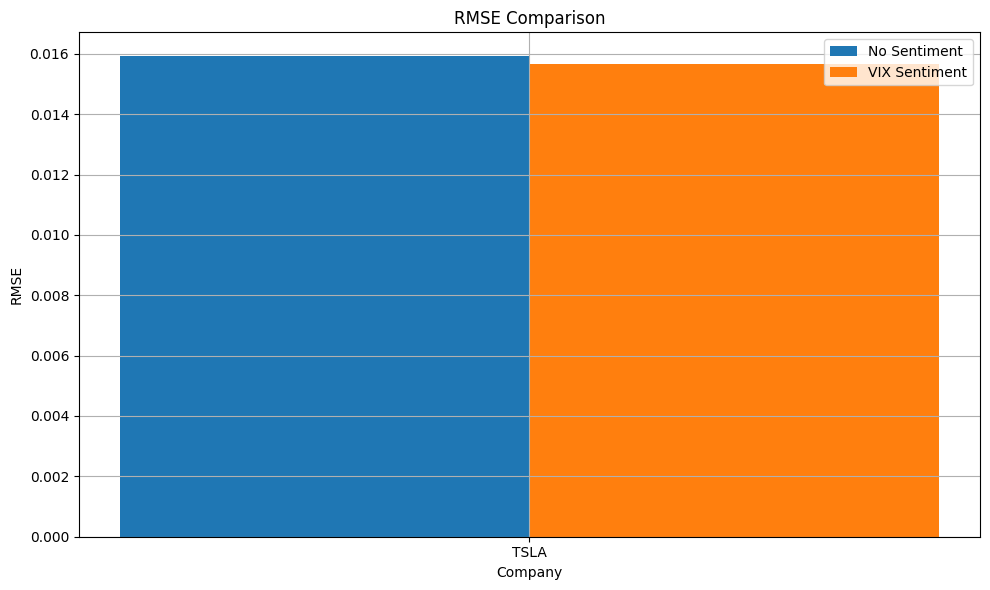

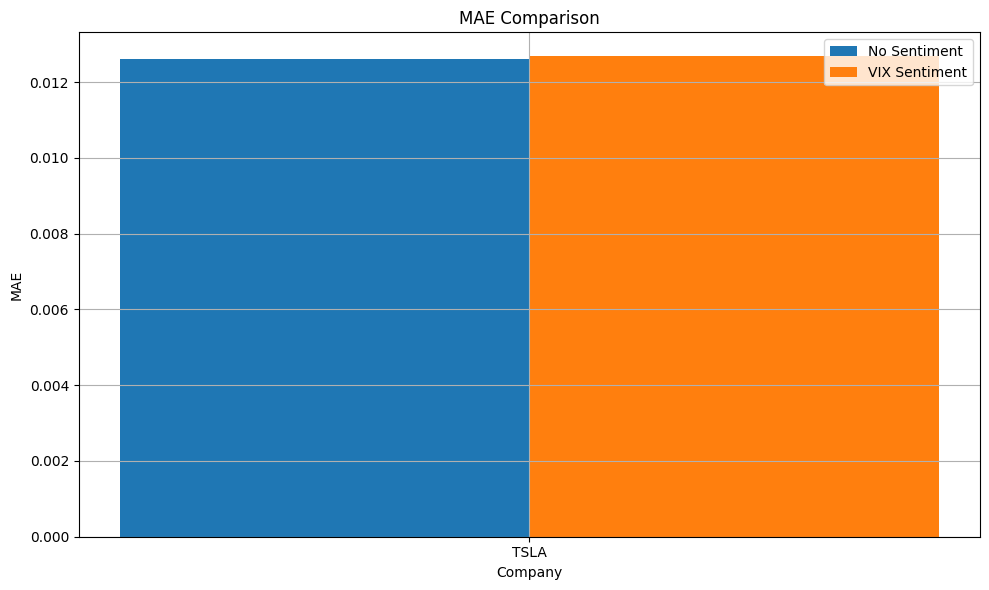

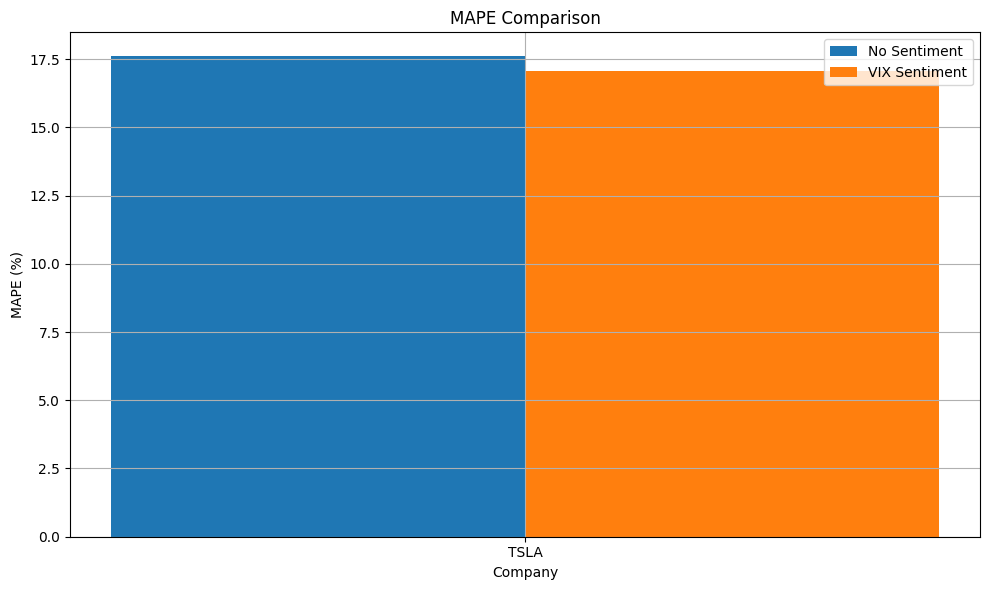

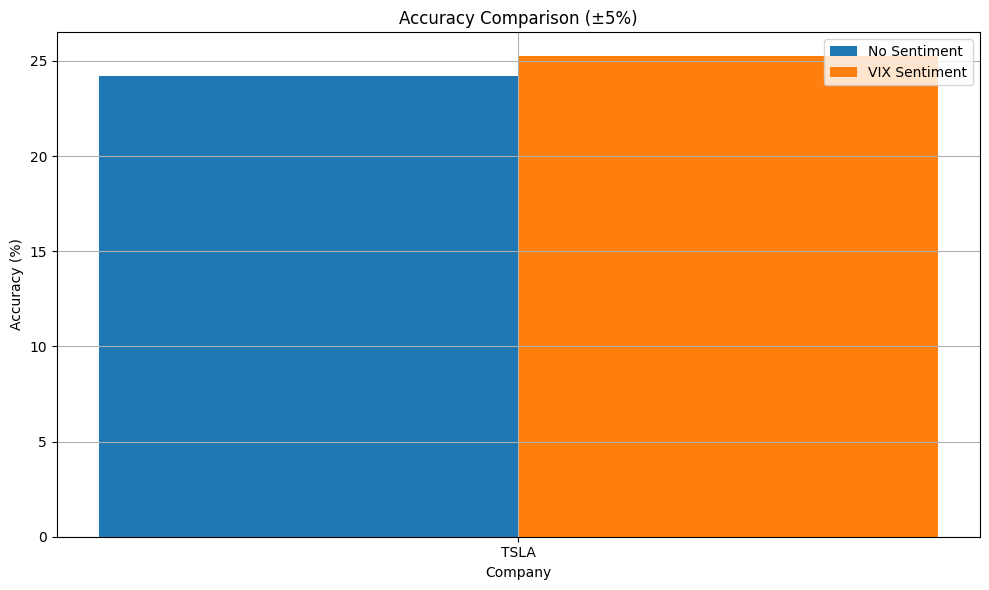


Final Results:
  Company  RMSE (no sentiment)  MAE (no sentiment)  MAPE (no sentiment)  \
0    TSLA             0.015916            0.012626            17.598433   

   Accuracy (no sentiment)  RMSE (with sentiment)  MAE (with sentiment)  \
0                24.205161               0.015675              0.012684   

   MAPE (with sentiment)  Accuracy (with sentiment)  
0              17.046696                  25.237097  


In [10]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
os.makedirs("results", exist_ok=True)
results_file_path = "./results/LSTM_results_vix_sentiment.csv"

# ------------------------------
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# ------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])
    return np.array(X), np.array(Y)

# ------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    total_samples = len(X)
    metrics_list = []

    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test  = X[start + train_window: start + train_window + test_window]
        Y_test  = Y[start + train_window: start + train_window + test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr): return lr * 0.99
        callback = LearningRateScheduler(scheduler)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)

        predictions = model.predict(X_test)
        rmse = calculate_rmse(Y_test, predictions)
        mae = calculate_mae(Y_test, predictions)
        mape = calculate_mape(Y_test, predictions)
        relative_errors = np.abs((Y_test - predictions) / np.where(Y_test == 0, 0.001, Y_test))
        accuracy = np.mean(relative_errors < threshold) * 100

        metrics_list.append((rmse, mae, mape, accuracy))

    return metrics_list

# ------------------------------
results = {
    'Company': [],
    'RMSE (no sentiment)': [], 'MAE (no sentiment)': [], 'MAPE (no sentiment)': [], 'Accuracy (no sentiment)': [],
    'RMSE (with sentiment)': [], 'MAE (with sentiment)': [], 'MAPE (with sentiment)': [], 'Accuracy (with sentiment)': []
}

stock_dict = {"Tesla": "TSLA"}
start_date = "2000-01-01"
end_date = "2025-03-01"
seq_size = 10
target_index = 3

# ------------------------------
# Load VIX
vix_df = yf.download("^VIX", start=start_date, end=end_date, progress=False)[['Close']]
vix_df.rename(columns={'Close': 'VIX'}, inplace=True)
vix_df.ffill(inplace=True)

# ------------------------------
for company_name, ticker in stock_dict.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].ffill()

    # No Sentiment
    df_no = df.copy()
    cols_no = df_no.columns[1:]
    data_no = df_no[cols_no].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size, target_index)
    metrics_no = rolling_window_evaluation(X_no, Y_no, seq_size, cols_no)
    rmse_no = np.mean([m[0] for m in metrics_no])
    mae_no = np.mean([m[1] for m in metrics_no])
    mape_no = np.mean([m[2] for m in metrics_no])
    acc_no = np.mean([m[3] for m in metrics_no])

    # With Sentiment = VIX
    df_with = df.copy()
    df_with = df_with.merge(vix_df, on="Date", how="left")
    df_with.rename(columns={"VIX": "Sentiment"}, inplace=True)
    df_with.ffill(inplace=True)
    cols_with = df_with.columns[1:]
    data_with = df_with[cols_with].values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size, target_index)
    metrics_with = rolling_window_evaluation(X_with, Y_with, seq_size, cols_with)
    rmse_with = np.mean([m[0] for m in metrics_with])
    mae_with = np.mean([m[1] for m in metrics_with])
    mape_with = np.mean([m[2] for m in metrics_with])
    acc_with = np.mean([m[3] for m in metrics_with])

    print(f"{company_name}: NoSent RMSE={rmse_no:.4f}, MAE={mae_no:.4f}, MAPE={mape_no:.2f}%, Acc={acc_no:.2f}% | "
          f"VIXSent RMSE={rmse_with:.4f}, MAE={mae_with:.4f}, MAPE={mape_with:.2f}%, Acc={acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['MAE (no sentiment)'].append(mae_no)
    results['MAPE (no sentiment)'].append(mape_no)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['MAE (with sentiment)'].append(mae_with)
    results['MAPE (with sentiment)'].append(mape_with)
    results['Accuracy (with sentiment)'].append(acc_with)

# ------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)

# ------------------------------
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    x = df_results['Company']
    no_sent = df_results[f'{metric_name} (no sentiment)']
    with_sent = df_results[f'{metric_name} (with sentiment)']

    bar_width = 0.35
    index = range(len(x))

    plt.bar(index, no_sent, bar_width, label='No Sentiment')
    plt.bar([i + bar_width for i in index], with_sent, bar_width, label='VIX Sentiment')

    plt.xlabel('Company')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([i + bar_width / 2 for i in index], x)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
plot_metric("RMSE", "RMSE Comparison", "RMSE")
plot_metric("MAE", "MAE Comparison", "MAE")
plot_metric("MAPE", "MAPE Comparison", "MAPE (%)")
plot_metric("Accuracy", "Accuracy Comparison (±5%)", "Accuracy (%)")

print("\nFinal Results:")
print(df_results)

YF.download() has changed argument auto_adjust default to True
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x371f5bec0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s

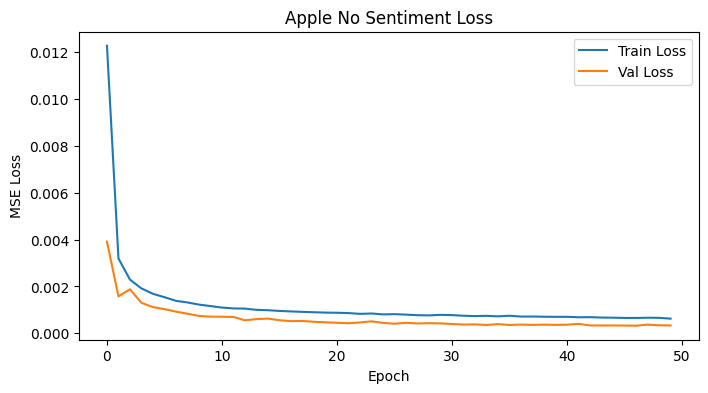

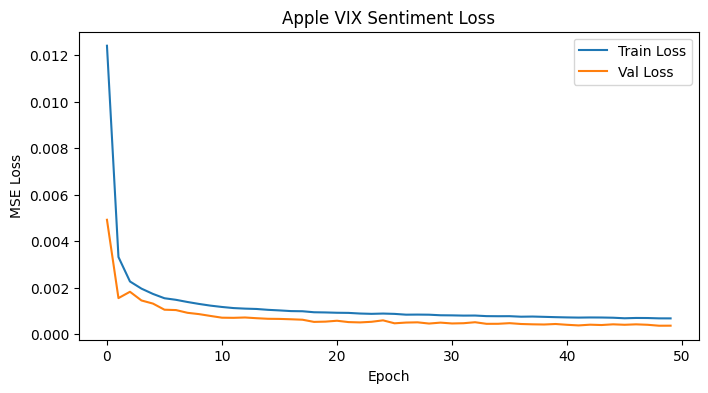

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━

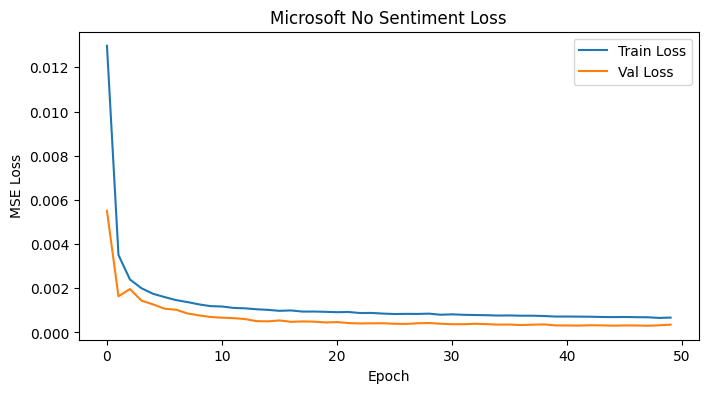

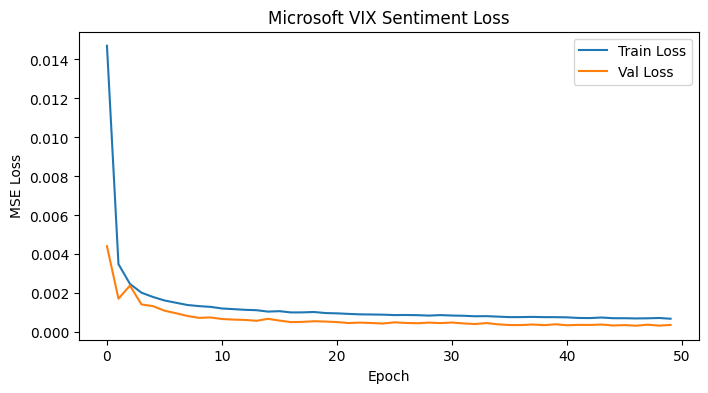


Final Results:
  Company  RMSE (no sentiment)  Accuracy (no sentiment)  \
0    AAPL             0.007141                33.996207   
1    MSFT             0.007263                33.868276   

   RMSE (with sentiment)  Accuracy (with sentiment)  
0               0.007216                  31.056379  
1               0.007331                  32.596724  


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
            Dropout(0.2),
            LSTM(32, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[LearningRateScheduler(lambda e,lr:lr*0.99)],
                            verbose=0)
        histories.append(history.history)

        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0,1e-3,Y_te)) < threshold) * 100
        metrics.append((rmse, accuracy))
    return metrics, histories

results = {'Company': [], 'RMSE (no sentiment)': [], 'Accuracy (no sentiment)': [],
           'RMSE (with sentiment)': [], 'Accuracy (with sentiment)': []}
target_idx = 3  # Close

# VIX 데이터 미리 로드
vix_df = yf.download("^VIX", start="2000-01-01", end="2025-03-01", progress=False)[['Close']]
vix_df = vix_df.rename(columns={'Close':'VIX'}).ffill()

for name, ticker in {"Apple":"AAPL","Microsoft":"MSFT"}.items():
    df = yf.download(ticker, start="2000-01-01", end="2025-03-01", progress=False)
    df.reset_index(inplace=True)
    df = df[['Date','Open','High','Low','Close','Volume']].ffill()

    # No sentiment
    data_no = df.iloc[:,1:].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size=10, target_idx=target_idx)
    metrics_no, hist_no = rolling_window_evaluation(X_no, Y_no, seq_size=10, columns=df.columns[1:])
    rmse_no = np.mean([m[0] for m in metrics_no])
    acc_no = np.mean([m[1] for m in metrics_no])

    # With VIX sentiment
    df_with = df.copy().set_index('Date').join(vix_df, how='left').ffill()
    data_with = df_with.values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size=10, target_idx=target_idx)
    metrics_with, hist_with = rolling_window_evaluation(
        X_with, Y_with, seq_size=10, columns=df_with.columns)
    rmse_with = np.mean([m[0] for m in metrics_with])
    acc_with = np.mean([m[1] for m in metrics_with])

    print(f"{name}: NoSent RMSE={rmse_no:.4f}, Acc={acc_no:.2f}% | VIXSent RMSE={rmse_with:.4f}, Acc={acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['Accuracy (with sentiment)'].append(acc_with)

    # 평균 Loss 시각화
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss'])>i]
            val_vals   = [h['val_loss'][i] for h in histories if len(h['val_loss'])>i]
            avg_train.append(np.mean(train_vals))
            avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8,4))
        plt.plot(avg_train, label='Train Loss')
        plt.plot(avg_val, label='Val Loss')
        plt.title(title); plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend(); plt.show()

    plot_avg_loss(hist_no, f"{name} No Sentiment Loss")
    plot_avg_loss(hist_with, f"{name} VIX Sentiment Loss")

df_results = pd.DataFrame(results)
df_results.to_csv("./results/LSTM_results_vix.csv", index=False)
print("\nFinal Results:")
print(df_results)

close vs OHLVC

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

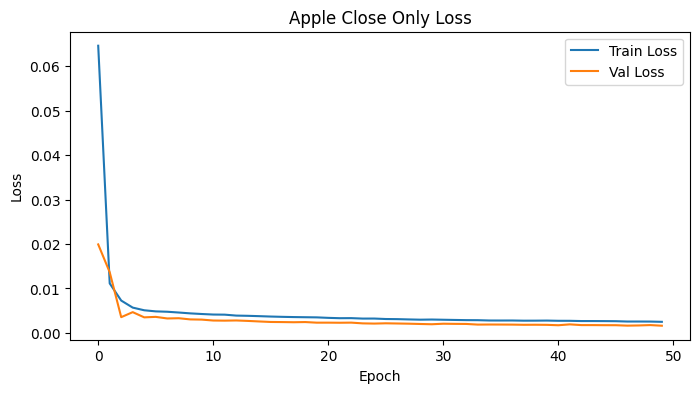

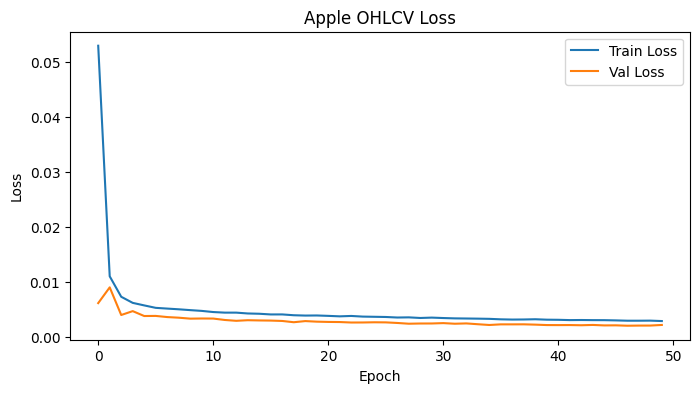

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

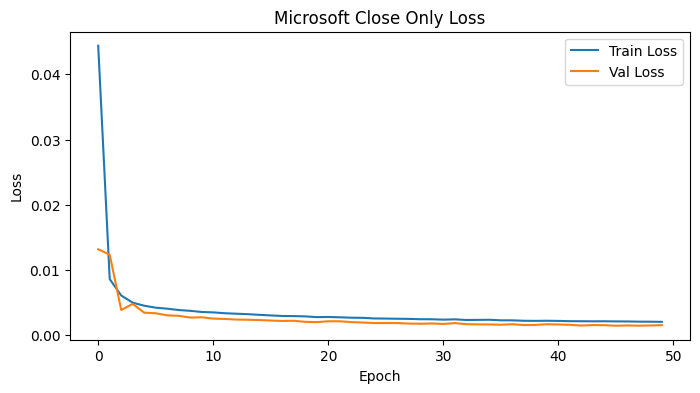

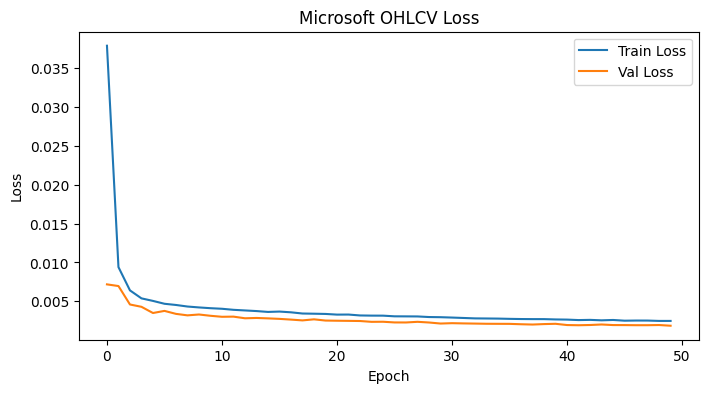


Final Results:
  Company  Close_Only_Accuracy  Close_Only_RMSE  Close_Only_MAE  \
0    AAPL            50.634921         0.036724        0.031288   
1    MSFT            44.571429         0.038355        0.032639   

   Close_Only_MAPE  OHLCV_Accuracy  OHLCV_RMSE  OHLCV_MAE  OHLCV_MAPE  
0         6.283450       48.941799    0.041482   0.035322    6.558748  
1         7.509569       45.899471    0.036680   0.030704    7.310847  


In [11]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-3, y_true))) * 100

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]
        
        # 완전한 Bi-LSTM 모델 구성
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, 
                                 kernel_regularizer=l2(1e-5),
                                 recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, 
                                 kernel_regularizer=l2(1e-5),
                                 recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[lr_scheduler],
                            verbose=0)
        histories.append(history.history)
        
        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0, 1e-3, Y_te)) < threshold) * 100
        metrics.append((accuracy, rmse, mae, mape))
    return metrics, histories

# 결과 저장 dict
results = {
    'Company': [],
    'Close_Only_Accuracy': [],
    'Close_Only_RMSE': [],
    'Close_Only_MAE': [],
    'Close_Only_MAPE': [],
    'OHLCV_Accuracy': [],
    'OHLCV_RMSE': [],
    'OHLCV_MAE': [],
    'OHLCV_MAPE': []
}

# 타겟 인덱스 설정
target_close_index = 0  # Close만 사용하면 0번째 열이 Close
target_ohlcv_index = 3  # OHLCV에서는 Close가 3번째 인덱스

start_date = "2020-01-01"
end_date = "2023-12-31"

for name, ticker in {"Apple": "AAPL", "Microsoft": "MSFT"}.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date','Open','High','Low','Close','Volume']].ffill()
    
    # 실험 1: Close Only → 단일 피처 입력
    data_close = df[['Close']].values.astype(float)
    scaled_close = MinMaxScaler().fit_transform(data_close)
    X_close, Y_close = create_dataset(scaled_close, seq_size=10, target_idx=target_close_index)
    metrics_close, hist_close = rolling_window_evaluation(X_close, Y_close, seq_size=10, columns=['Close'])
    metrics_close = np.array(metrics_close)
    acc_close, rmse_close, mae_close, mape_close = metrics_close.mean(axis=0)
    
    # 실험 2: OHLCV → 5개 피처 입력
    data_ohlcv = df[['Open','High','Low','Close','Volume']].values.astype(float)
    scaled_ohlcv = MinMaxScaler().fit_transform(data_ohlcv)
    X_ohlcv, Y_ohlcv = create_dataset(scaled_ohlcv, seq_size=10, target_idx=target_ohlcv_index)
    metrics_ohlcv, hist_ohlcv = rolling_window_evaluation(X_ohlcv, Y_ohlcv, seq_size=10, columns=['Open','High','Low','Close','Volume'])
    metrics_ohlcv = np.array(metrics_ohlcv)
    acc_ohlcv, rmse_ohlcv, mae_ohlcv, mape_ohlcv = metrics_ohlcv.mean(axis=0)
    
    print(f"{name}:")
    print(f"  Close Only - Accuracy: {acc_close:.2f}%, RMSE: {rmse_close:.4f}, MAE: {mae_close:.4f}, MAPE: {mape_close:.2f}%")
    print(f"  OHLCV      - Accuracy: {acc_ohlcv:.2f}%, RMSE: {rmse_ohlcv:.4f}, MAE: {mae_ohlcv:.4f}, MAPE: {mape_ohlcv:.2f}%\n")
    
    results['Company'].append(ticker)
    results['Close_Only_Accuracy'].append(acc_close)
    results['Close_Only_RMSE'].append(rmse_close)
    results['Close_Only_MAE'].append(mae_close)
    results['Close_Only_MAPE'].append(mape_close)
    results['OHLCV_Accuracy'].append(acc_ohlcv)
    results['OHLCV_RMSE'].append(rmse_ohlcv)
    results['OHLCV_MAE'].append(mae_ohlcv)
    results['OHLCV_MAPE'].append(mape_ohlcv)
    
    # 평균 Loss 시각화 함수
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss']) > i]
            val_vals = [h['val_loss'][i] for h in histories if len(h['val_loss']) > i]
            avg_train.append(np.mean(train_vals))
            avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8, 4))
        plt.plot(avg_train, label='Train Loss')
        plt.plot(avg_val, label='Val Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    plot_avg_loss(hist_close, f"{name} Close Only Loss")
    plot_avg_loss(hist_ohlcv, f"{name} OHLCV Loss")

df_results = pd.DataFrame(results)
df_results.to_csv("./results/LSTM_results_close_vs_ohlcv.csv", index=False)
print("\nFinal Results:")
print(df_results)

## OHLCV 히트맵 , RandomForest 피처임포턴스, PCA 2D 치원축소


🎯 분석 대상: AAPL (2020-01-01 ~ 2023-12-31)


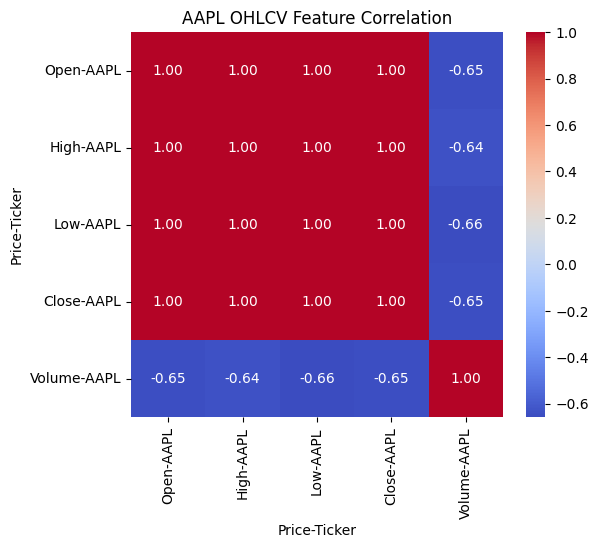

/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/1140019183.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_feat = df['Close'].shift(-1).fillna(method='ffill')  # 다음 날 종가 예측
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


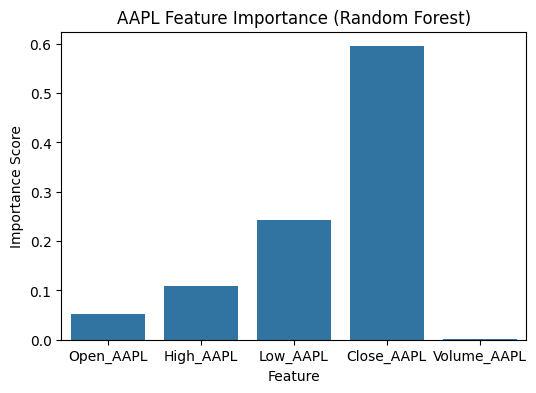

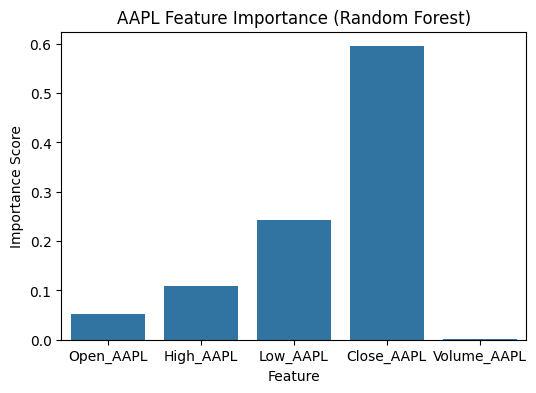


📉 PCA Explained Variance Ratio:
  PC1: 0.8957
  PC2: 0.1037


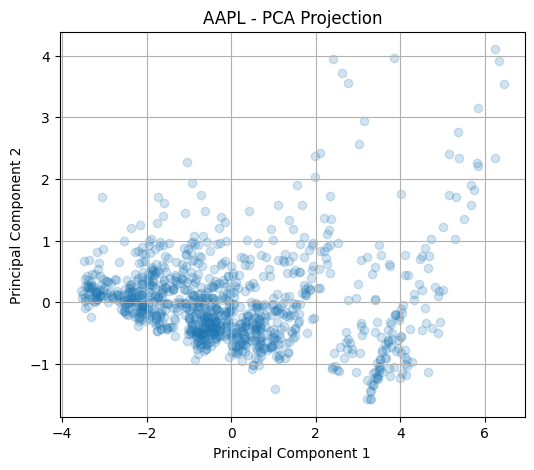

In [18]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 분석할 종목과 기간
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-12-31"

# 데이터 다운로드 및 전처리
df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].ffill()

print(f"\n🎯 분석 대상: {ticker} ({start_date} ~ {end_date})")

# 📊 1. 상관계수 히트맵
plt.figure(figsize=(6, 5))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"{ticker} OHLCV Feature Correlation")
plt.show()

# 🧠 2. Feature Importance (Random Forest)
X_feat = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# 💡 MultiIndex가 있을 경우 단일 인덱스로 변환
if isinstance(X_feat.columns, pd.MultiIndex):
    X_feat.columns = ['_'.join(col).strip() for col in X_feat.columns.values]
else:
    X_feat.columns = X_feat.columns.astype(str)

y_feat = df['Close'].shift(-1).fillna(method='ffill')  # 다음 날 종가 예측

# 모델 학습
rf = RandomForestRegressor(random_state=42)
rf.fit(X_feat, y_feat)

# 중요도 시각화
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_feat.columns,
    'Importance': importances
})

plt.figure(figsize=(6, 4))
sns.barplot(data=importance_df, x='Feature', y='Importance')
plt.title(f"{ticker} Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=importance_df, x='Feature', y='Importance')
plt.title(f"{ticker} Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

# 📉 3. PCA 분석
scaler = StandardScaler()
scaled = scaler.fit_transform(X_feat)

pca = PCA(n_components=2)
pca.fit(scaled)

print(f"\n📉 PCA Explained Variance Ratio:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {ratio:.4f}")

# 2D PCA 시각화 (optional)
pca_data = pca.transform(scaled)
plt.figure(figsize=(6, 5))
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.2)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"{ticker} - PCA Projection")
plt.grid(True)
plt.show()

차원축소
	•	Open, High, Low, Close가 강하게 연관된 구조라는 걸 시사합니다.
	•	Volume이 다소 독립적인 정보일 수도 있습니다 (주성분 기여도가 낮을 가능성).
	•	고차원 입력을 PCA 2D로 축소한 후 LSTM 입력에 활용하는 것도 실험 가치가 있습니다.

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import ReduceLROnPlateau

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-3, y_true))) * 100

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    metrics = []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        model.fit(X_tr, Y_tr, validation_data=(X_te, Y_te), epochs=epochs, batch_size=batch_size,
                  callbacks=[lr_scheduler], verbose=0)
        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0, 1e-3, Y_te)) < threshold) * 100
        metrics.append((accuracy, rmse, mae, mape))
    return np.array(metrics).mean(axis=0)

# 📥 데이터 다운로드
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01", end="2023-12-31", progress=False)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].ffill()
target_idx_ohlcv = 3  # Close
target_idx_ohlc = 3   # Close

seq_size = 10

# [1] OHLCV (원본 입력)
scaled_ohlcv = MinMaxScaler().fit_transform(df)
X_ohlcv, Y_ohlcv = create_dataset(scaled_ohlcv, seq_size=seq_size, target_idx=target_idx_ohlcv)
res_ohlcv = rolling_window_evaluation(X_ohlcv, Y_ohlcv, seq_size, columns=['Open','High','Low','Close','Volume'])

# [2] OHLC (Volume 제거)
df_ohlc = df[['Open','High','Low','Close']]
scaled_ohlc = MinMaxScaler().fit_transform(df_ohlc)
X_ohlc, Y_ohlc = create_dataset(scaled_ohlc, seq_size=seq_size, target_idx=target_idx_ohlc)
res_ohlc = rolling_window_evaluation(X_ohlc, Y_ohlc, seq_size, columns=['Open','High','Low','Close'])

# [3] OHLCV → PCA 2D
scaled_std_ohlcv = StandardScaler().fit_transform(df)
pca_ohlcv = PCA(n_components=2)
pca_ohlcv_2d = pca_ohlcv.fit_transform(scaled_std_ohlcv)
X_pca_ohlcv, Y_pca_ohlcv = create_dataset(pca_ohlcv_2d, seq_size=seq_size, target_idx=1)
res_pca_ohlcv = rolling_window_evaluation(X_pca_ohlcv, Y_pca_ohlcv, seq_size, columns=['PC1','PC2'])

# [4] OHLC → PCA 2D
scaled_std_ohlc = StandardScaler().fit_transform(df_ohlc)
pca_ohlc = PCA(n_components=2)
pca_ohlc_2d = pca_ohlc.fit_transform(scaled_std_ohlc)
X_pca_ohlc, Y_pca_ohlc = create_dataset(pca_ohlc_2d, seq_size=seq_size, target_idx=1)
res_pca_ohlc = rolling_window_evaluation(X_pca_ohlc, Y_pca_ohlc, seq_size, columns=['PC1','PC2'])

# ✅ 결과 출력
print(f"\n📊 Performance Comparison for {ticker}")
print(f"[1] OHLCV         → Accuracy: {res_ohlcv[0]:.2f}%, RMSE: {res_ohlcv[1]:.4f}, MAE: {res_ohlcv[2]:.4f}, MAPE: {res_ohlcv[3]:.2f}%")
print(f"[2] OHLC          → Accuracy: {res_ohlc[0]:.2f}%, RMSE: {res_ohlc[1]:.4f}, MAE: {res_ohlc[2]:.4f}, MAPE: {res_ohlc[3]:.2f}%")
print(f"[3] OHLCV (PCA)   → Accuracy: {res_pca_ohlcv[0]:.2f}%, RMSE: {res_pca_ohlcv[1]:.4f}, MAE: {res_pca_ohlcv[2]:.4f}, MAPE: {res_pca_ohlcv[3]:.2f}%")
print(f"[4] OHLC (PCA)    → Accuracy: {res_pca_ohlc[0]:.2f}%, RMSE: {res_pca_ohlc[1]:.4f}, MAE: {res_pca_ohlc[2]:.4f}, MAPE: {res_pca_ohlc[3]:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/

차원축소 효과 없다. V도 상관계수로 비교하면 떨어지지만, 성능면에서 봤을때 아예 의미 없다고 볼 수 없는것 같다.

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-3, y_true))) * 100

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    # 각 rolling window마다 (정확도, RMSE, MAE, MAPE)를 계산
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        # 완전한 Bi-LSTM 모델: 두 층 모두 Bidirectional 처리
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, 
                                 kernel_regularizer=l2(1e-5),
                                 recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, 
                                 kernel_regularizer=l2(1e-5),
                                 recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        # Huber loss 사용 (delta=1.0)
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))

        # 동적 학습률 감소: 검증 손실 개선이 없으면 학습률 감소
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[lr_scheduler],
                            verbose=0)
        histories.append(history.history)

        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        # Accuracy: 예측값이 실제값과 threshold 내 차이가 나는 비율
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0, 1e-3, Y_te)) < threshold) * 100
        
        metrics.append((accuracy, rmse, mae, mape))
    return metrics, histories

# 결과를 저장할 dict (두 모델: No sentiment와 VIX sentiment)
results = {'Company': [],
           'Accuracy (no sentiment)': [], 'RMSE (no sentiment)': [], 'MAE (no sentiment)': [], 'MAPE (no sentiment)': [],
           'Accuracy (with sentiment)': [], 'RMSE (with sentiment)': [], 'MAE (with sentiment)': [], 'MAPE (with sentiment)': []}
target_idx = 3  # 종가 (Close)

# 데이터 기간: 2020-01-01 ~ 2023-12-31 (기본 테스트)
start_date = "2020-01-01"
end_date = "2023-12-31"

# VIX 데이터 미리 로드
vix_df = yf.download("^VIX", start=start_date, end=end_date, progress=False)[['Close']]
vix_df = vix_df.rename(columns={'Close': 'VIX'}).ffill()

for name, ticker in {"Apple": "AAPL", "Microsoft": "MSFT"}.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].ffill()

    # No sentiment 모델
    data_no = df.iloc[:, 1:].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size=10, target_idx=target_idx)
    metrics_no, hist_no = rolling_window_evaluation(X_no, Y_no, seq_size=10, columns=df.columns[1:])
    # 평균 계산: 순서 = (accuracy, rmse, mae, mape)
    metrics_no = np.array(metrics_no)
    acc_no, rmse_no, mae_no, mape_no = metrics_no.mean(axis=0)

    # VIX sentiment 모델: VIX 피처를 join
    df_with = df.copy().set_index('Date').join(vix_df, how='left').ffill()
    data_with = df_with.values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size=10, target_idx=target_idx)
    metrics_with, hist_with = rolling_window_evaluation(X_with, Y_with, seq_size=10, columns=df_with.columns)
    metrics_with = np.array(metrics_with)
    acc_with, rmse_with, mae_with, mape_with = metrics_with.mean(axis=0)

    print(f"{name}:")
    print(f"  No Sentiment - Accuracy: {acc_no:.2f}%, RMSE: {rmse_no:.4f}, MAE: {mae_no:.4f}, MAPE: {mape_no:.2f}%")
    print(f"  VIX Sentiment - Accuracy: {acc_with:.2f}%, RMSE: {rmse_with:.4f}, MAE: {mae_with:.4f}, MAPE: {mape_with:.2f}%\n")

    results['Company'].append(ticker)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['MAE (no sentiment)'].append(mae_no)
    results['MAPE (no sentiment)'].append(mape_no)
    results['Accuracy (with sentiment)'].append(acc_with)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['MAE (with sentiment)'].append(mae_with)
    results['MAPE (with sentiment)'].append(mape_with)

    # 평균 Loss 시각화
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss']) > i]
            val_vals = [h['val_loss'][i] for h in histories if len(h['val_loss']) > i]
            avg_train.append(np.mean(train_vals))
            avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8, 4))
        plt.plot(avg_train, label='Train Loss')
        plt.plot(avg_val, label='Val Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    plot_avg_loss(hist_no, f"{name} No Sentiment Loss")
    plot_avg_loss(hist_with, f"{name} VIX Sentiment Loss")

df_results = pd.DataFrame(results)
df_results.to_csv("./results/LSTM_results_vix.csv", index=False)
print("\nFinal Results:")
print(df_results)

## CASE3 (OHLCV + VIX + Statistics[RSI, MACD, Bollinger B])

### ============================================
###  목적: LSTM 기반 주가 예측 성능 비교 실험
#### - 입력 피처 구성에 따라 모델 성능이 어떻게 달라지는지 비교
#### - 실험 대상:
####   [1] Base: OHLCV만 사용
####   [2] VIX Sentiment: OHLCV + VIX (공포/탐욕 감성지표)
####   [3] Hybrid: OHLCV + VIX + 기술적 지표 (RSI, MACD, Bollinger %B)
#### - 성능 지표: Accuracy, RMSE, MAE, MAPE
#### - 시각화를 통해 성능 차이를 직관적으로 확인
### ============================================

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2275891717.py:143: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


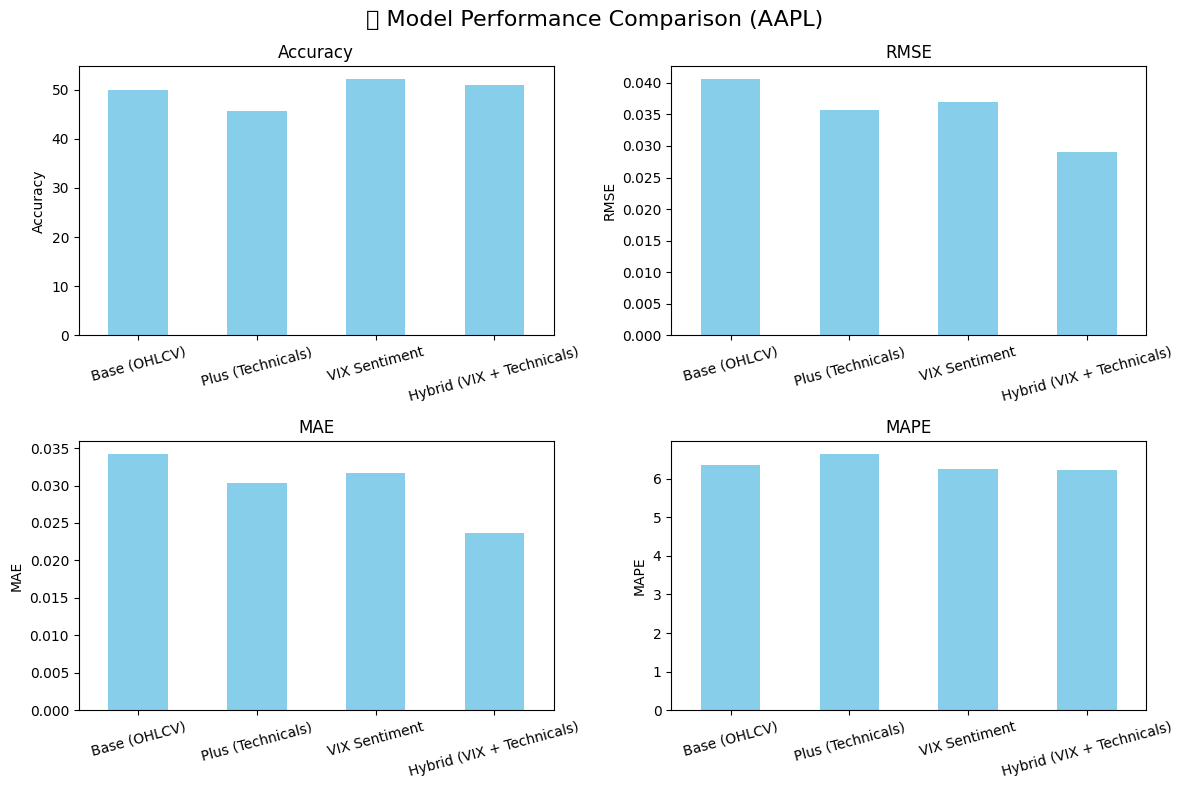

                            Accuracy      RMSE       MAE      MAPE
Base (OHLCV)               49.989418  0.040590  0.034185  6.357796
Plus (Technicals)          45.634921  0.035732  0.030380  6.634616
VIX Sentiment              52.158730  0.036993  0.031615  6.241245
Hybrid (VIX + Technicals)  51.010582  0.029023  0.023650  6.218691


In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import ta  # 기술적 지표 라이브러리

# =============================================================================
# 목적:
# 1. AAPL 주가 데이터를 Yahoo Finance에서 다운로드하고, VIX 및 기술적 지표(RSI, MACD, BBP)를 계산
# 2. OHLCV, OHLCV+Technicals, OHLCV+VIX, OHLCV+VIX+Technicals 네 가지 variant를 구성 (df_plus 포함)
# 3. 각 variant에 대해 정규화 후, 연속 10일치 데이터를 입력으로 다음 날의 종가를 예측하는 LSTM 모델을
#    rolling window 방식으로 학습 및 평가하여 성능(Accuracy, RMSE, MAE, MAPE)을 산출
# 4. variant별 모델 성능을 시각화하여 비교 분석
# =============================================================================

# ========================== Helper Functions ============================

# RMSE 계산 함수
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE 계산 함수
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100

# 시계열 LSTM 입력 형식으로 변환하는 함수
# 입력 시퀀스를 만들고, 각 시퀀스 이후의 종가를 타겟으로 설정
def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i + seq_size])
        Y.append(data[i + seq_size, target_idx])
    return np.array(X), np.array(Y)

# 롤링 윈도우 방식으로 LSTM 모델을 학습하고 평가하는 함수
# 일정 구간만큼 학습 후 다음 구간을 테스트하는 구조
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=30, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    metrics = []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        # 학습/테스트 분할
        X_tr, Y_tr = X[start:start + train_window], Y[start:start + train_window]
        X_te, Y_te = X[start + train_window:start + train_window + test_window], Y[start + train_window:start + train_window + test_window]

        # Bi-LSTM 모델 구성
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))

        # 검증 손실 개선 없을 시 학습률 감소
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)

        # 모델 학습
        model.fit(X_tr, Y_tr, validation_data=(X_te, Y_te),
                  epochs=epochs, batch_size=batch_size,
                  callbacks=[lr_scheduler], verbose=0)

        # 예측 및 평가 지표 계산
        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te == 0, 1e-3, Y_te)) < threshold) * 100
        metrics.append((accuracy, rmse, mae, mape))

    return np.array(metrics).mean(axis=0)

# ============================ Data Loading ==============================

# 실험 대상 주식 및 날짜 범위 설정
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-12-31"
seq_size = 10
target_idx = 3  # 'Close'가 네 번째 컬럼

# 주가 데이터 다운로드 및 결측값 처리
df = yf.download(ticker, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']].ffill()

# VIX 데이터 다운로드 및 결측값 처리
vix = yf.download("^VIX", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'VIX'}).ffill()

# 기술적 지표 추가 (RSI, MACD, Bollinger %B)
close_series = df['Close'].squeeze()
df['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
df['MACD'] = ta.trend.MACD(close=close_series).macd_diff()
df['BBP'] = ta.volatility.BollingerBands(close=close_series).bollinger_pband()
df = df.ffill().bfill()  # NaN 제거: forward fill 후 backward fill

# ========================== Dataset Variants ============================

# Base 모델: OHLCV만 사용
df_base = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Plus 모델: OHLCV + 기술적 지표 3종 (RSI, MACD, BBP)
df_plus = df_base.join(df[['RSI', 'MACD', 'BBP']], how='left').ffill()

# VIX 모델: OHLCV + VIX
df_vix = df_base.join(vix, how='left').ffill()

# Hybrid 모델: OHLCV + VIX + 기술적 지표 3종
df_hybrid = df_vix.join(df[['RSI', 'MACD', 'BBP']], how='left').ffill()

# 실험 대상 리스트 및 라벨 (4가지 variant)
variants = [df_base, df_plus, df_vix, df_hybrid]
labels = ['Base (OHLCV)', 'Plus (Technicals)', 'VIX Sentiment', 'Hybrid (VIX + Technicals)']

# ======================== Model Training ================================

results = []
for df_model in variants:
    data = df_model.values.astype(float)
    scaled = MinMaxScaler().fit_transform(data)  # 정규화
    X, Y = create_dataset(scaled, seq_size=seq_size, target_idx=target_idx)
    metrics = rolling_window_evaluation(X, Y, seq_size, columns=df_model.columns)
    results.append(metrics)

# ====================== Visualization ===================================

# 결과 DataFrame 생성 및 시각화
results_df = pd.DataFrame(results, columns=['Accuracy', 'RMSE', 'MAE', 'MAPE'], index=labels)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    results_df[results_df.columns[i]].plot(kind='bar', ax=ax, title=results_df.columns[i], color='skyblue')
    ax.set_ylabel(results_df.columns[i])
    ax.set_xticklabels(results_df.index, rotation=15)

plt.suptitle("📊 Model Performance Comparison (AAPL)", fontsize=16)
plt.tight_layout()
plt.show()

# 결과 출력
print(results_df)

## CASE4 (OHLCV + DailyNEWS Sentiment)

### =============================================================================
### 목적:
#### 1. FinBERT를 이용해 AAPL 뉴스 제목에서 감성 분석 수행 및 감성 점수 산출
#### 2. 날짜별 뉴스 감성 점수(평균)를 계산하고, MinMax 정규화 수행
#### 3. Yahoo Finance에서 OHLCV 데이터를 로드하고, 감성 점수와 병합하여 LSTM 입력용 데이터셋 생성
#### 4. LSTM 모델을 구축하여 감성 피처가 없는 경우(기본)와 감성 피처가 포함된 경우의 성능 비교
#### 5. 두 모델의 성능(Accuracy, RMSE, MAE, MAPE)을 CSV로 저장하고, 시각화하여 비교 분석
### =============================================================================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Device set to use mps:0
[*********************100%***********************]  1 of 1 completed

뉴스 개수 (날짜별):
            date ticker  news_count
0     2020-01-01   AAPL           5
1     2020-01-02   AAPL           5
2     2020-01-03   AAPL           5
3     2020-01-04   AAPL           5
4     2020-01-05   AAPL           5
...          ...    ...         ...
1455  2023-12-27   AAPL           5
1456  2023-12-28   AAPL           5
1457  2023-12-29   AAPL           5
1458  2023-12-30   AAPL           5
1459  2023-12-31   AAPL           5

[1460 rows x 3 columns]
✅ FinBERT 감성 분석 및 LSTM 입력용 피처 생성 완료


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step
✅ LSTM 성능 비교 완료 (with sentiment vs no sentiment)
  ticker  Accuracy_no_sentiment  RMSE_no_sentiment  MAE_no_sentiment  \
0   AAPL              30.888109           0.038143          0.032743   

   MAPE_no_sentiment  Accuracy_with_sentiment  RMSE_with_sentiment  \
0           9.669982                  31.4386             0.033787   

   MAE_with_sentiment  MAPE_with_sentiment  
0            0.028873             9.615633  


/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0

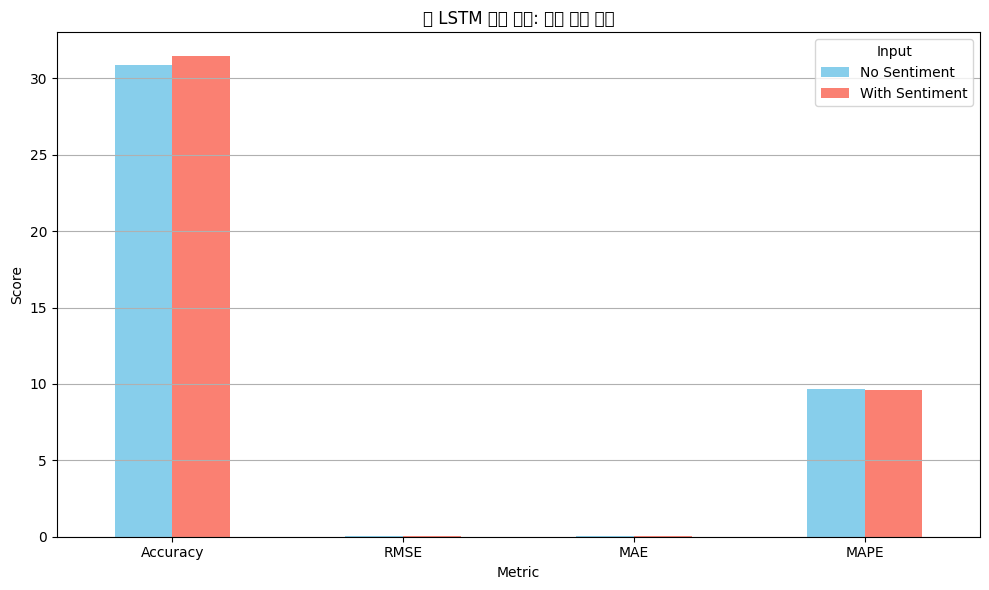

📊 감성 분석 유무 성능 비교 시각화 완료


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import yfinance as yf

# ====================== Step 1. FinBERT 로드 ===========================
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# ====================== Step 2. 뉴스 데이터 로드 ========================
df_news = pd.read_csv("/Users/parkchangyu/Githubrepo/Finance-insights/results/news/AAPL_news.csv")

# 날짜 포맷 통일 & ticker 컬럼 추가
df_news['date'] = pd.to_datetime(df_news['Date']).dt.date
df_news['ticker'] = 'AAPL'  # 단일 종목 처리

# 감성 점수 변환 함수 (1~100 스케일)
def sentiment_score(label):
    return {
        'positive': 90,
        'neutral': 50,
        'negative': 10
    }.get(label.lower(), 50)

# 감성 분석 실행 (Title 기준)
def analyze_sentiments(df):
    # 각 뉴스 제목에 대해 FinBERT 감성 분석 실행
    df['sentiment'] = df['Title'].apply(lambda x: finbert(x)[0]['label'])
    df['score'] = df['sentiment'].apply(sentiment_score)
    return df

df_scored = analyze_sentiments(df_news)
df_scored.to_csv("news_scored.csv", index=False)

# 날짜별 뉴스 기사 개수 확인 (디버깅용)
news_count = df_scored.groupby(['date', 'ticker']).size().reset_index(name='news_count')
print("뉴스 개수 (날짜별):")
print(news_count)

# =================== Step 3. 감성 점수 집계 =============================
# 날짜별 뉴스 기사 5건의 감성 점수 평균 계산
mean_sent = df_scored.groupby(['date', 'ticker'])['score'].mean().reset_index().rename(columns={'score': 'sentiment_mean'})
scaler_mean = MinMaxScaler()
mean_sent['sentiment_mean_scaled'] = scaler_mean.fit_transform(mean_sent[['sentiment_mean']])

# =================== Step 4. OHLCV 병합 (Yahoo Finance에서 로드) ===============================
ticker_list = df_scored['ticker'].unique()
df_ohlcv_all = []
for ticker in ticker_list:
    # 시작/종료 날짜는 뉴스 데이터의 최소, 최대 날짜 사용
    df_ticker = yf.download(ticker, start=str(df_scored['date'].min()), end=str(df_scored['date'].max()))
    df_ticker = df_ticker[['Open', 'High', 'Low', 'Close', 'Volume']].reset_index()
    # 컬럼 이름을 소문자로 변환 (tuple이면 첫 요소 사용)
    df_ticker.columns = [col[0].lower() if isinstance(col, tuple) else col.lower() for col in df_ticker.columns]
    df_ticker['ticker'] = ticker
    df_ohlcv_all.append(df_ticker)
df_ohlcv = pd.concat(df_ohlcv_all)
df_ohlcv['date'] = pd.to_datetime(df_ohlcv['date']).dt.date

# 병합 전 인덱스 초기화
mean_sent = mean_sent.reset_index(drop=True)
df_ohlcv = df_ohlcv.reset_index(drop=True)

# 감성 점수 병합 (df_mean: OHLCV + 감성)
df_mean = pd.merge(df_ohlcv, mean_sent[['date', 'ticker', 'sentiment_mean_scaled']], on=['date', 'ticker'], how='left')
df_mean['sentiment_mean_scaled'] = df_mean['sentiment_mean_scaled'].fillna(0)

# 저장 (참고용)
df_ohlcv.to_csv("lstm_input_without_sentiment.csv", index=False)
df_mean.to_csv("lstm_input_with_sentiment.csv", index=False)

print("✅ FinBERT 감성 분석 및 LSTM 입력용 피처 생성 완료")


# ============================================
# LSTM 모델 학습 및 성능 비교 (감성 유무)
# ============================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 평가 함수
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100

# 데이터셋 생성 함수
def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

# 1) Baseline: OHLCV만 사용 (감성 없음)
def train_lstm_model_without_sentiment(df_input, label='no_sentiment'):
    df_input = df_input.sort_values(by=['ticker', 'date'])
    results = []
    for ticker in df_input['ticker'].unique():
        df_t = df_input[df_input['ticker'] == ticker].copy()
        df_t = df_t[['open', 'high', 'low', 'close', 'volume']]
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df_t)
        X, Y = create_dataset(scaled, seq_size=10, target_idx=3)
        
        model = Sequential([
            Input(shape=(10, X.shape[2])),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        
        split = int(len(X) * 0.8)
        X_train, Y_train = X[:split], Y[:split]
        X_test, Y_test = X[split:], Y[split:]
        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=0)
        preds = model.predict(X_test)
        
        rmse = calculate_rmse(Y_test, preds)
        mae = mean_absolute_error(Y_test, preds)
        mape = calculate_mape(Y_test, preds)
        accuracy = np.mean(np.abs((Y_test - preds)/np.where(Y_test==0,1e-3,Y_test)) < 0.05) * 100
        results.append((ticker, accuracy, rmse, mae, mape))
        
    return pd.DataFrame(results, columns=['ticker', f'Accuracy_{label}', f'RMSE_{label}', f'MAE_{label}', f'MAPE_{label}'])

# 2) With Sentiment: OHLCV + 감성 점수 (여기서는 sentiment_mean_scaled 사용)
def train_lstm_model_with_sentiment(df_input, sentiment_column, label='with_sentiment'):
    df_input = df_input.sort_values(by=['ticker', 'date'])
    results = []
    for ticker in df_input['ticker'].unique():
        df_t = df_input[df_input['ticker'] == ticker].copy()
        df_t = df_t[['open', 'high', 'low', 'close', 'volume', sentiment_column]]
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df_t)
        X, Y = create_dataset(scaled, seq_size=10, target_idx=3)
        
        model = Sequential([
            Input(shape=(10, X.shape[2])),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        
        split = int(len(X) * 0.8)
        X_train, Y_train = X[:split], Y[:split]
        X_test, Y_test = X[split:], Y[split:]
        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=0)
        preds = model.predict(X_test)
        
        rmse = calculate_rmse(Y_test, preds)
        mae = mean_absolute_error(Y_test, preds)
        mape = calculate_mape(Y_test, preds)
        accuracy = np.mean(np.abs((Y_test - preds)/np.where(Y_test==0,1e-3,Y_test)) < 0.05) * 100
        results.append((ticker, accuracy, rmse, mae, mape))
        
    return pd.DataFrame(results, columns=['ticker', f'Accuracy_{label}', f'RMSE_{label}', f'MAE_{label}', f'MAPE_{label}'])

# Baseline 결과 (감성 없음)
df_baseline_result = train_lstm_model_without_sentiment(df_ohlcv, label='no_sentiment')
# 감성 포함 결과 (감성 있음)
df_sentiment_result = train_lstm_model_with_sentiment(df_mean, sentiment_column='sentiment_mean_scaled', label='with_sentiment')

# 결과 비교
df_compare = pd.merge(df_baseline_result, df_sentiment_result, on='ticker')
df_compare.to_csv("sentiment_vs_baseline_comparison_result.csv", index=False)
print("✅ LSTM 성능 비교 완료 (with sentiment vs no sentiment)")
print(df_compare)

# =============================================
# 감성 유무 LSTM 성능 비교 시각화
import matplotlib.pyplot as plt

df_compare = pd.read_csv("sentiment_vs_baseline_comparison_result.csv")
mean_metrics = df_compare[[
    'Accuracy_no_sentiment', 'RMSE_no_sentiment', 'MAE_no_sentiment', 'MAPE_no_sentiment',
    'Accuracy_with_sentiment', 'RMSE_with_sentiment', 'MAE_with_sentiment', 'MAPE_with_sentiment'
]].mean().to_frame(name='score')

plot_df = pd.DataFrame({
    'Metric': ['Accuracy', 'RMSE', 'MAE', 'MAPE'],
    'No Sentiment': [
        mean_metrics.loc['Accuracy_no_sentiment', 'score'],
        mean_metrics.loc['RMSE_no_sentiment', 'score'],
        mean_metrics.loc['MAE_no_sentiment', 'score'],
        mean_metrics.loc['MAPE_no_sentiment', 'score']
    ],
    'With Sentiment': [
        mean_metrics.loc['Accuracy_with_sentiment', 'score'],
        mean_metrics.loc['RMSE_with_sentiment', 'score'],
        mean_metrics.loc['MAE_with_sentiment', 'score'],
        mean_metrics.loc['MAPE_with_sentiment', 'score']
    ]
})

plot_df.set_index('Metric').plot(kind='bar', figsize=(10,6), color=['skyblue','salmon'])
plt.title("📈 LSTM 성능 비교: 감성 분석 유무")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Input')
plt.tight_layout()
plt.show()

print("📊 감성 분석 유무 성능 비교 시각화 완료")

## CASE5 (OHLCV + DailyNEWS Sentiment + VIX + Statistics[RSI,MACD,Bollinger B])

Device set to use mps:0
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Hybrid+News 모델 성능 (Accuracy, RMSE, MAE, MAPE):
[4.90476190e+01 3.19757748e-02 2.64184427e-02 6.36323735e+00]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


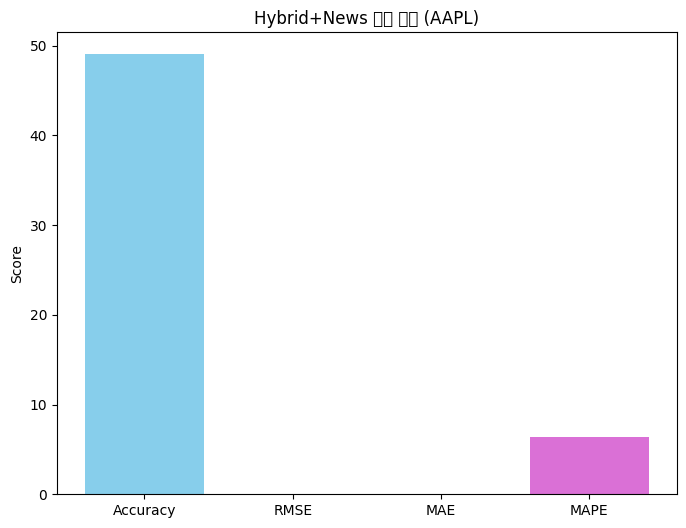

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import ta  # 기술적 지표 라이브러리
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

# =============================================================================
# 목적:
# 1. AAPL 주가 데이터를 Yahoo Finance에서 다운로드하고, VIX 및 기술적 지표(RSI, MACD, BBP)를 계산
# 2. Hybrid+News 모델 구성: OHLCV + VIX + 기술적 지표에 FinBERT 기반 뉴스 감성 피처(sentiment_mean_scaled)를 병합
# 3. 이 데이터에 대해 정규화 후, 연속 10일치 데이터를 입력으로 다음 날의 종가를 예측하는 LSTM 모델을
#    rolling window 방식으로 학습 및 평가하여 성능(Accuracy, RMSE, MAE, MAPE)을 산출
# 4. Hybrid+News 모델의 성능을 출력 및 시각화
# =============================================================================

# ========================== Helper Functions ============================
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i + seq_size])
        Y.append(data[i + seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=30, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    metrics = []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start + train_window], Y[start:start + train_window]
        X_te, Y_te = X[start + train_window:start + train_window + test_window], Y[start + train_window:start + train_window + test_window]
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        model.fit(X_tr, Y_tr, validation_data=(X_te, Y_te),
                  epochs=epochs, batch_size=batch_size,
                  callbacks=[lr_scheduler], verbose=0)
        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te == 0, 1e-3, Y_te)) < threshold) * 100
        metrics.append((accuracy, rmse, mae, mape))
    return np.array(metrics).mean(axis=0)

# ============================ News Sentiment Processing ==============================
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model_finbert = BertForSequenceClassification.from_pretrained(model_name)
finbert = pipeline("sentiment-analysis", model=model_finbert, tokenizer=tokenizer)

df_news = pd.read_csv("/Users/parkchangyu/Githubrepo/Finance-insights/results/news/AAPL_news.csv")
df_news['date'] = pd.to_datetime(df_news['Date']).dt.date
df_news['ticker'] = 'AAPL'  # 단일 종목 처리

def sentiment_score(label):
    return {'positive': 90, 'neutral': 50, 'negative': 10}.get(label.lower(), 50)

def analyze_sentiments(df):
    df['sentiment'] = df['Title'].apply(lambda x: finbert(x)[0]['label'])
    df['score'] = df['sentiment'].apply(sentiment_score)
    return df

df_scored = analyze_sentiments(df_news)
df_scored.to_csv("news_scored.csv", index=False)
mean_sent = df_scored.groupby(['date', 'ticker'])['score'].mean().reset_index().rename(columns={'score': 'sentiment_mean'})
scaler_mean = MinMaxScaler()
mean_sent['sentiment_mean_scaled'] = scaler_mean.fit_transform(mean_sent[['sentiment_mean']])
mean_sent['date'] = pd.to_datetime(mean_sent['date'])  # dtype 통일

# ============================ Data Loading & Preprocessing ==============================
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-12-31"
seq_size = 10
target_idx = 3  # 'Close' 컬럼

df = yf.download(ticker, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']].ffill()
vix = yf.download("^VIX", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'VIX'}).ffill()

close_series = df['Close'].squeeze()
df['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
df['MACD'] = ta.trend.MACD(close=close_series).macd_diff()
df['BBP'] = ta.volatility.BollingerBands(close=close_series).bollinger_pband()
df = df.ffill().bfill()

# ========================== Dataset Variant: Hybrid+News ============================
# Hybrid 모델: OHLCV + VIX + 기술적 지표 (RSI, MACD, BBP)
df_base = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df_vix = df_base.join(vix, how='left').ffill()
df_hybrid = df_vix.join(df[['RSI', 'MACD', 'BBP']], how='left').ffill()

# Hybrid+News: Hybrid 모델에 뉴스 감성 피처 추가
df_hybrid = df_hybrid.reset_index()   # 인덱스를 리셋하여 'Date' 컬럼 생성
# 평탄화: MultiIndex 컬럼이 있다면 단일 레벨로 변환
if isinstance(df_hybrid.columns, pd.MultiIndex):
    df_hybrid.columns = df_hybrid.columns.get_level_values(0)
df_hybrid.rename(columns={'Date': 'date'}, inplace=True)
df_hybrid['date'] = pd.to_datetime(df_hybrid['date'])
df_hybrid['ticker'] = ticker  # ticker 컬럼 추가

# merge 시도: 양쪽의 'date' 컬럼 dtype이 datetime64[ns]임을 확인
df_hybrid_news = pd.merge(df_hybrid, mean_sent[['date', 'ticker', 'sentiment_mean_scaled']],
                          on=['date', 'ticker'], how='left')
df_hybrid_news['sentiment_mean_scaled'] = df_hybrid_news['sentiment_mean_scaled'].fillna(0)

# ======================== Model Training ================================
# 모델 입력으로 사용할 숫자형 데이터만 사용 ('date'와 'ticker' 컬럼 제거)
data = df_hybrid_news.drop(columns=['date', 'ticker']).values.astype(float)
scaled = MinMaxScaler().fit_transform(data)
X, Y = create_dataset(scaled, seq_size=seq_size, target_idx=target_idx)
metrics = rolling_window_evaluation(X, Y, seq_size, columns=df_hybrid_news.drop(columns=['date', 'ticker']).columns)

# ====================== Visualization & Result ==========================
print("Hybrid+News 모델 성능 (Accuracy, RMSE, MAE, MAPE):")
print(metrics)

plt.figure(figsize=(8, 6))
plt.bar(['Accuracy', 'RMSE', 'MAE', 'MAPE'], metrics, color=['skyblue', 'salmon', 'lightgreen', 'orchid'])
plt.title("Hybrid+News 모델 성능 (AAPL)")
plt.ylabel("Score")
plt.show()